In [1]:
import numpy as np
import pandas as pd
import datetime
import holidays
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings

# 한글
mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='Malgun Gothic')
warnings.filterwarnings('ignore')


# df : DataFrame
# df.index : datetime64 type
# start, end : str('YYYY-MM-DD')
def slicing(df, start, end):
    dateRange = pd.date_range(start, end)
    return df[df['date'].isin(dateRange)]


# df_covid 전처리 (2019-01-01 ~ 2021-07-31)
df_covid = pd.read_csv('002_2.COVID-19.csv')
df_covid['DATE']= df_covid['DATE'].astype('str')
df_covid['DATE'] = pd.to_datetime(df_covid['DATE'])
df_covid.rename(columns= {'ID' : 'COUNT'}, inplace=True)
df_covid = df_covid.groupby(['DATE']).count()
df_covid.insert(0, 'date', df_covid.index)
df_covid = df_covid[{'date', 'COUNT'}]

#df_subway 전처리 (2019-01-01 ~ 2021-07-31)
df_subway = pd.read_csv('002_1.DAILY_SUBWAY_INFO.csv')
df_subway['date']= df_subway['date'].astype('str')
df_subway['date'] = pd.to_datetime(df_subway['date'])
df_subway = df_subway.drop(['on_num', 'off_num'], axis=1)

# df에 df_subway, df_covid 합치기
df = pd.merge(df_subway, df_covid, how='outer', on='date')
df = df.fillna(0)
df['COUNT'] = df['COUNT'].astype('Int64')
df['total'] = df['total'].astype('Int64')

# df_subway_kor 전처리
df_subway_kor = pd.read_csv('002_3.COVID-19_IN_KOREA.csv', thousands = ',')
df_subway_kor = df_subway_kor.iloc[1:].loc[:, ['date', 'total']]
df_subway_kor['date']= df_subway_kor['date'].astype('str')
df_subway_kor['date'] = pd.to_datetime(df_subway_kor['date'])

# df에 df_subway_kor 합치기
df = pd.merge(df, df_subway_kor, how='outer', on='date')
df.columns = ['date', 'subway', 'COVID-19', 'COVID-19 KOR']
df = df.fillna(0)
df['COVID-19 KOR'] = df['COVID-19 KOR'].astype('Int64')

# df_biz : Business day (법정공휴일, 주말 제외)
holidays = holidays.Korea()
datetime.date(2019, 1, 1) in holidays
datetime.date(2020, 1, 1) in holidays
datetime.date(2021, 1, 1) in holidays
df_biz = df[~df['date'].isin(list(holidays.keys()))]
df_biz = df_biz[df_biz['date'].dt.dayofweek < 5].copy()
df_biz = df_biz.set_index('date')
df = df.set_index('date')

# df_week : 주 단위로 묶기 (평균, 합계, 합계)
df_week = pd.DataFrame()
df_week['subway'] = df_biz['subway'].resample('7D').mean()
df_week['COVID-19'] = df_biz['COVID-19'].resample('7D').sum()
df_week['COVID-19 KOR'] = df_biz['COVID-19 KOR'].resample('7D').sum()

#data type을 float로 통일
df = df.astype('float')
df_biz = df_biz.astype('float')
df_week = df_week.astype('float')

df = df.reset_index()
df_biz = df_biz.reset_index()
df_week = df_week.reset_index()



In [2]:
pd.set_option('display.max_row', 1500)

## 전처리

In [7]:
# df_week를 2020-01-31 ~ 2021-07-27 으로 slicing 한 다음
# column에 'increase' 추가 (전국 신규확진자 수 변화량)
df_week1 = slicing(df_week, '2020-01-31', '2021-07-27')
df_week1_previous_week = slicing(df_week, '2020-01-24', '2021-07-20')

# 다음 line에서 series끼리 뺄셈을 하기 위해서 index를 통일
df_week1_previous_week.set_index(df_week1.index, inplace=True)

# 전주 대비 증가량
df_week1['increase'] = (df_week1['COVID-19 KOR'] \
                    - df_week1_previous_week['COVID-19 KOR'])

# 전주 대비 증가율(%)
df_week1['increase percent'] = 100 * df_week1['increase'] \
                    / df_week1_previous_week['COVID-19 KOR']
df_week1


,date,subway,COVID-19,COVID-19 KOR,increase,increase percent
57,2020-02-05,1.400990e+07,4.0,9.0,1.0,12.500000
58,2020-02-12,1.454700e+07,0.0,2.0,-7.0,-77.777778
59,2020-02-19,1.313774e+07,29.0,461.0,459.0,22950.000000
60,2020-02-26,1.037252e+07,37.0,2415.0,1954.0,423.861171
61,2020-03-04,1.029042e+07,87.0,1851.0,-564.0,-23.354037
62,2020-03-11,1.042368e+07,55.0,624.0,-1227.0,-66.288493
63,2020-03-18,1.069349e+07,64.0,472.0,-152.0,-24.358974
64,2020-03-25,1.087733e+07,85.0,498.0,26.0,5.508475
65,2020-04-01,1.109752e+07,74.0,370.0,-128.0,-25.702811
66,2020-04-08,1.145851e+07,27.0,171.0,-199.0,-53.783784


In [12]:
df_week1.shape

(77, 6)

## 시각화

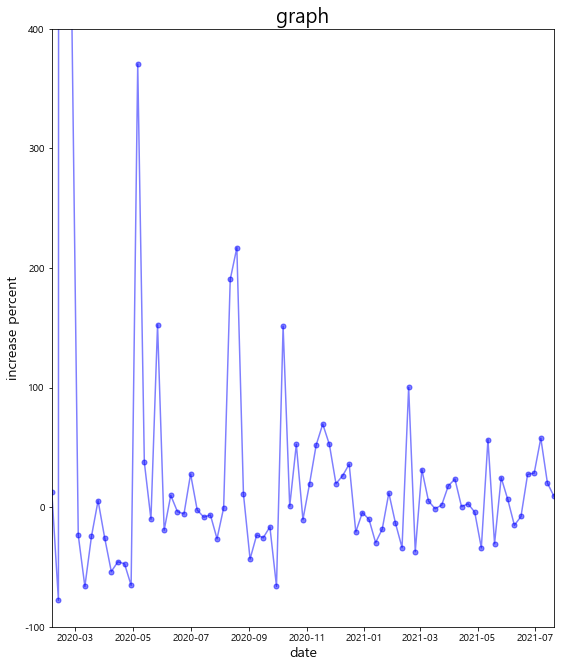

In [34]:

    plt.figure(figsize=(9,11))
    plt.axis([df_week1['date'].iloc[0], df_week1['date'].iloc[76], -100, 400])
    plt.plot('date',

             'increase percent',

             data=df_week1,

             linestyle='solid', 

             marker='o', 

             markersize=5,

             color='blue', 

             alpha=0.5)

    plt.title("graph", fontsize=20)

    plt.xlabel('date', fontsize=14)

    plt.ylabel('increase percent', fontsize=14)
    
#     plt.text(13200000, 2200, '2021-07-21', size=25)

    
    plt.show()

In [16]:
df_week1.corr()

,subway,COVID-19,COVID-19 KOR,increase,increase percent
subway,1.000000,-0.158873,-0.224688,0.041579,0.070324
COVID-19,-0.158873,1.000000,0.957764,0.418705,-0.099268
COVID-19 KOR,-0.224688,0.957764,1.000000,0.418441,-0.082258
increase,0.041579,0.418705,0.418441,1.000000,0.083481
increase percent,0.070324,-0.099268,-0.082258,0.083481,1.000000


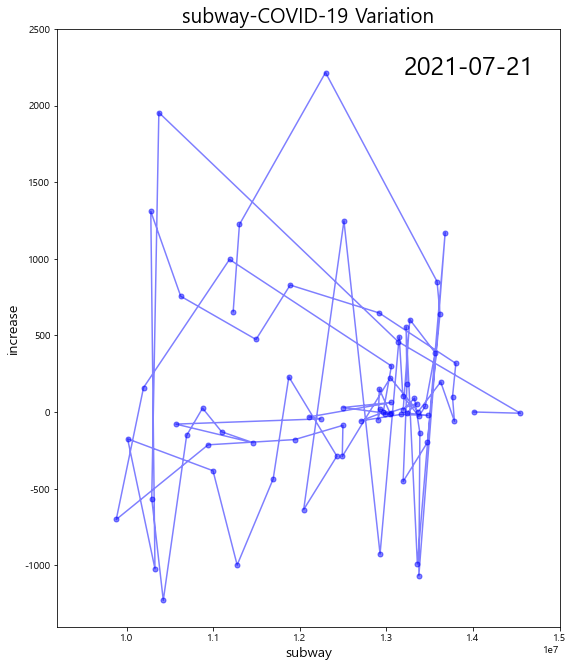

In [36]:
# test : subway - increase

plt.figure(figsize=(9,11))
plt.axis([9200000, 15000000, -1400, 2500])
plt.plot('subway',

         'increase',

         data=df_week1,

         linestyle='solid', 

         marker='o', 

         markersize=5,

         color='blue', 

         alpha=0.5)

plt.title("subway-COVID-19 Variation", fontsize=20)

plt.xlabel('subway', fontsize=14)

plt.ylabel('increase', fontsize=14)

plt.text(13200000, 2200, '2021-07-21', size=25)


plt.show()

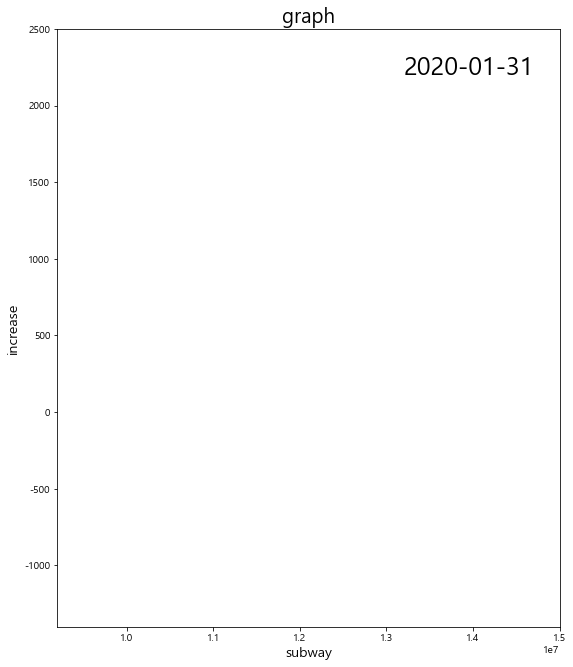

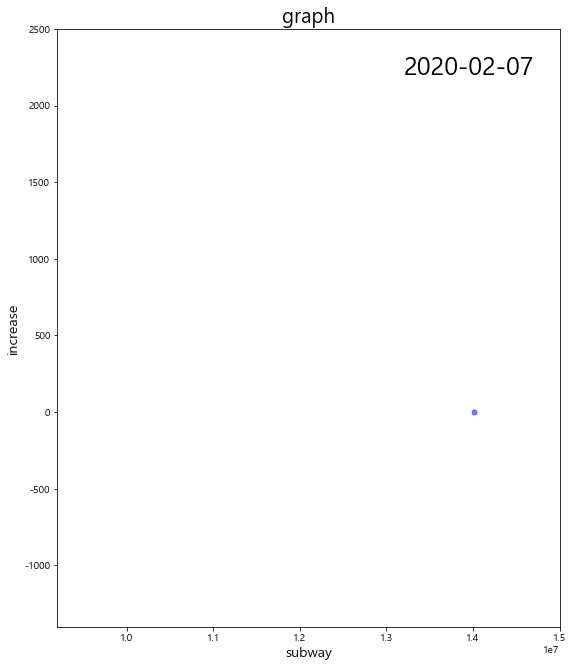

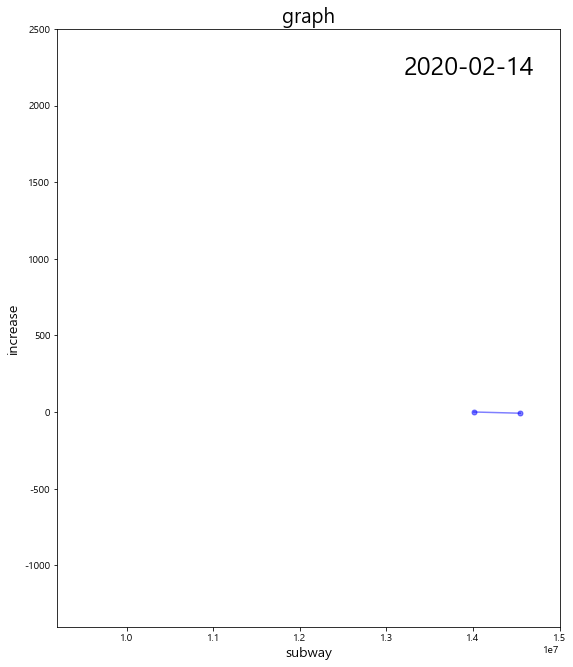

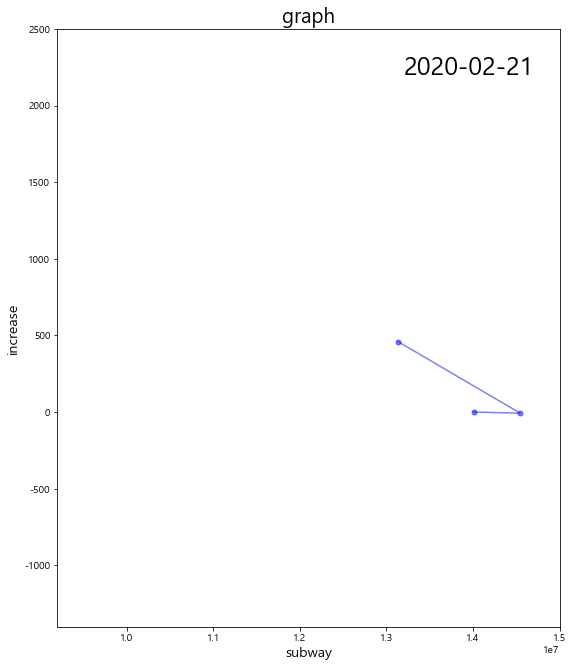

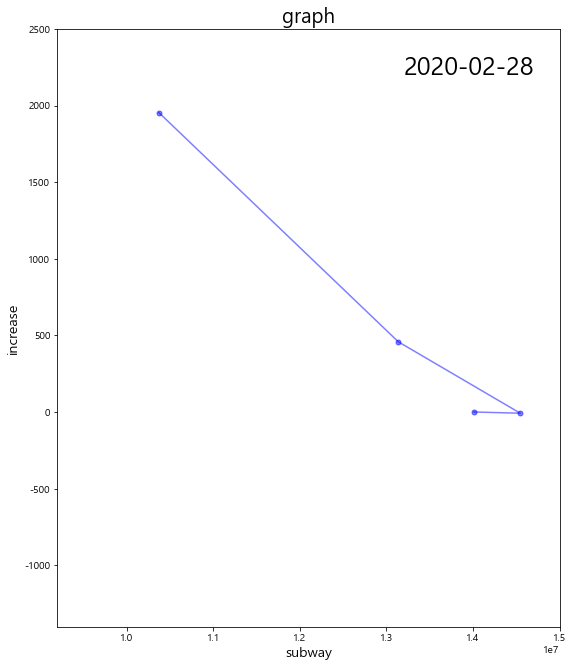

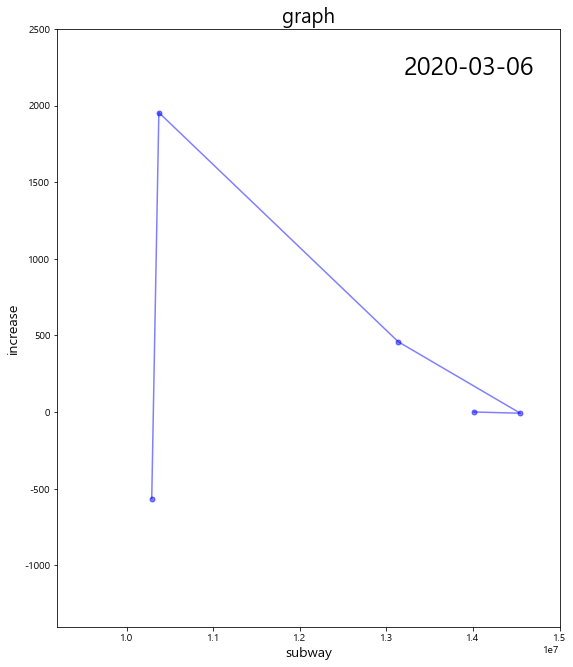

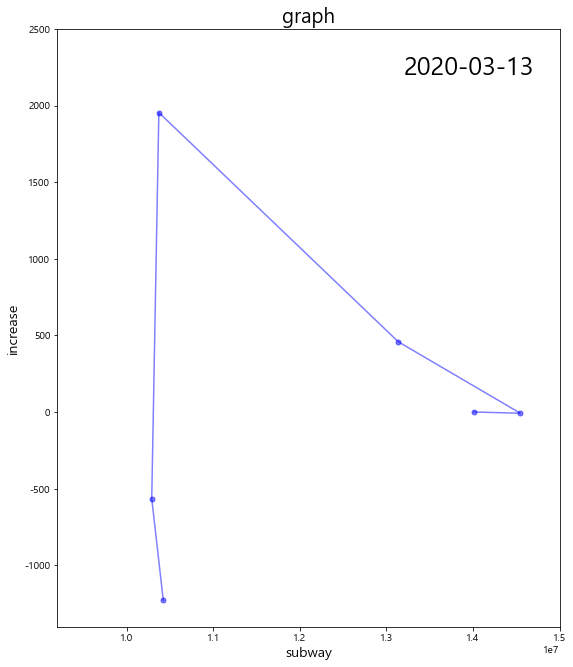

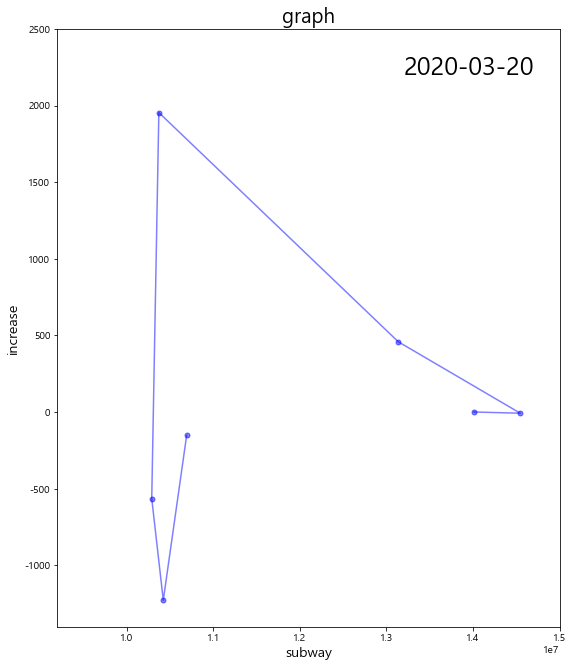

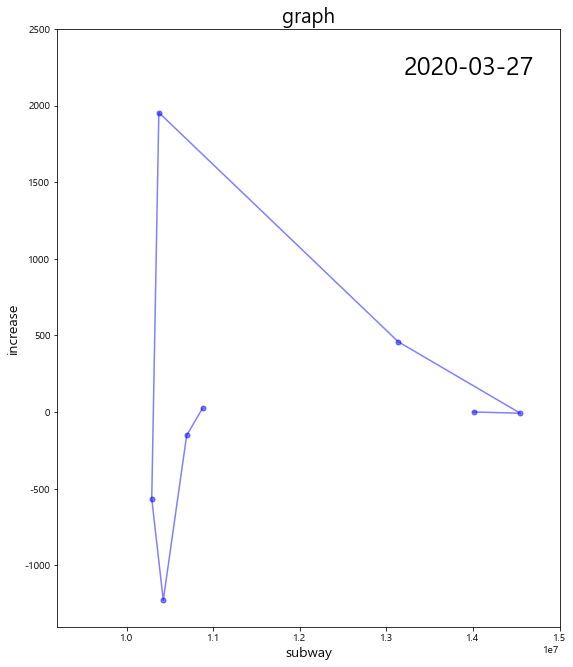

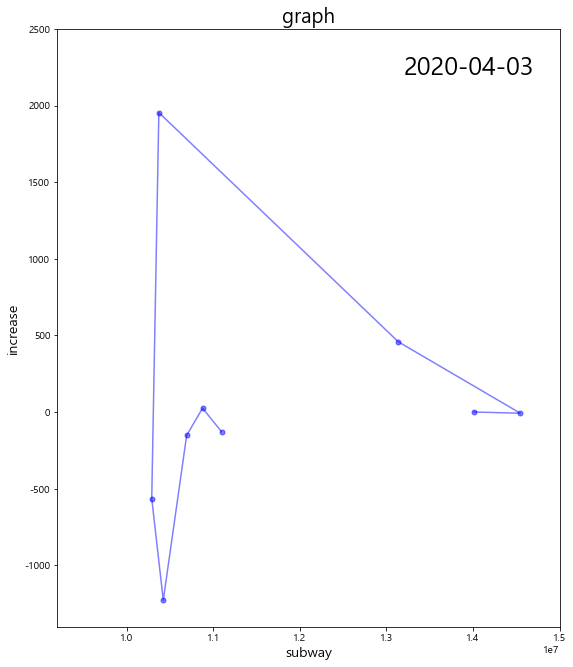

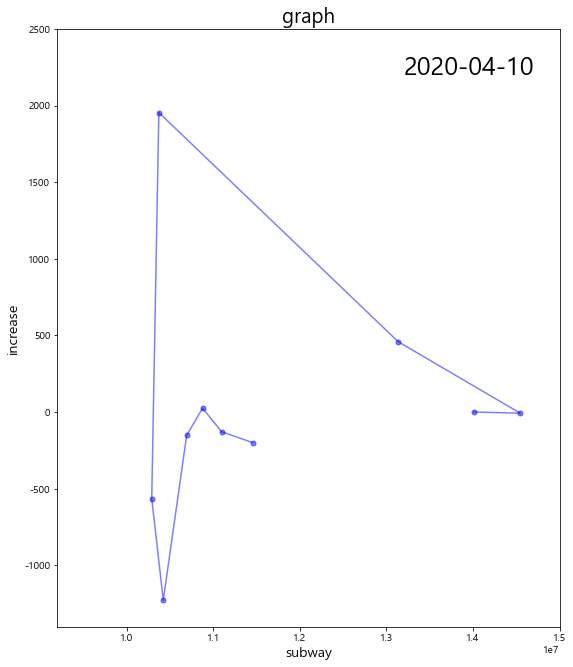

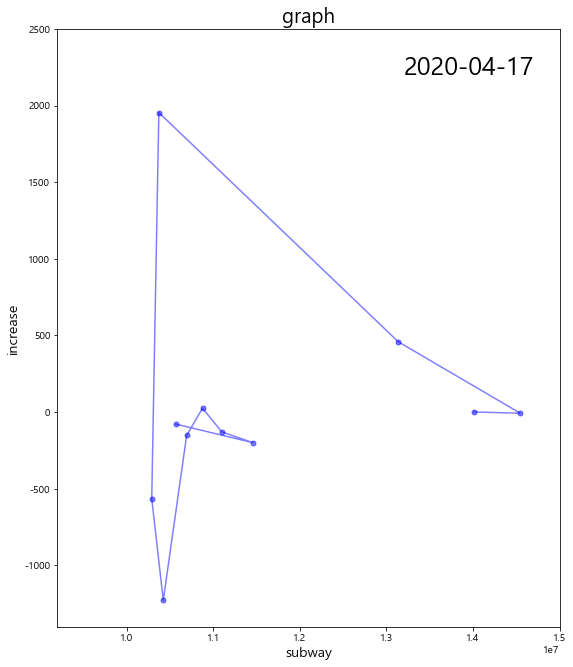

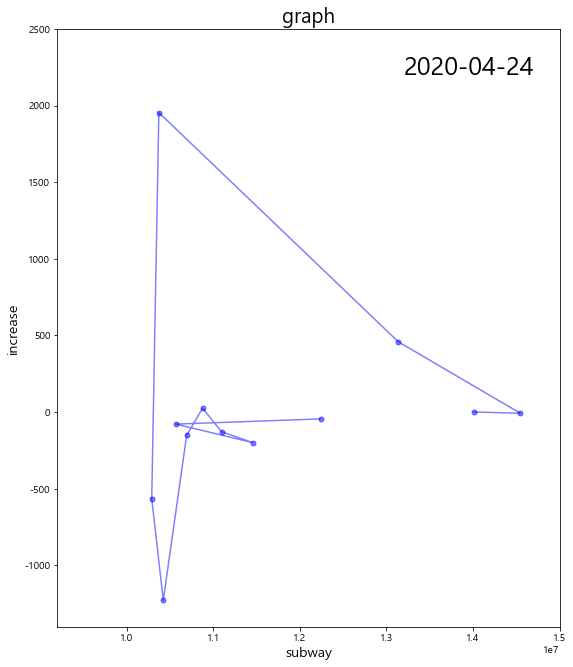

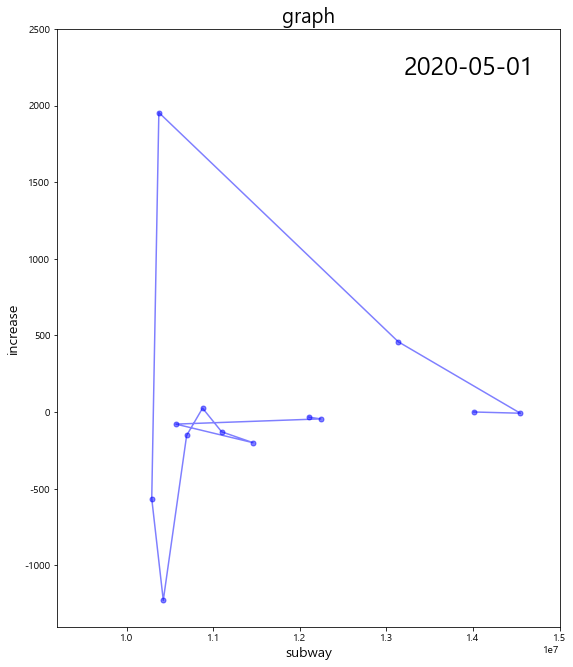

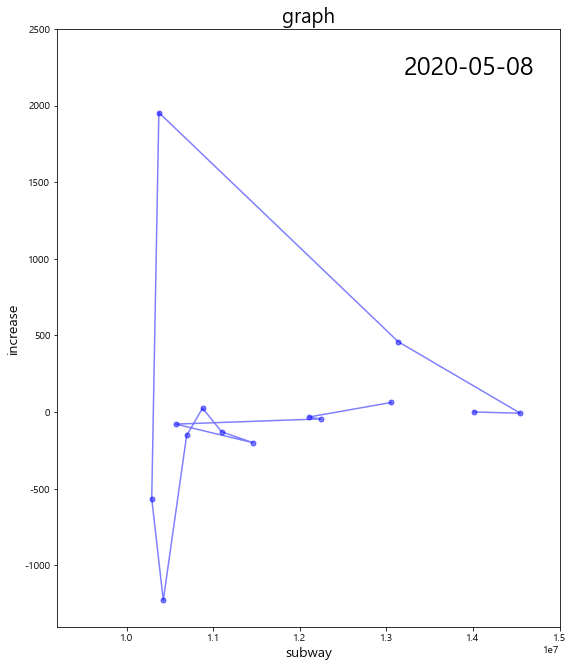

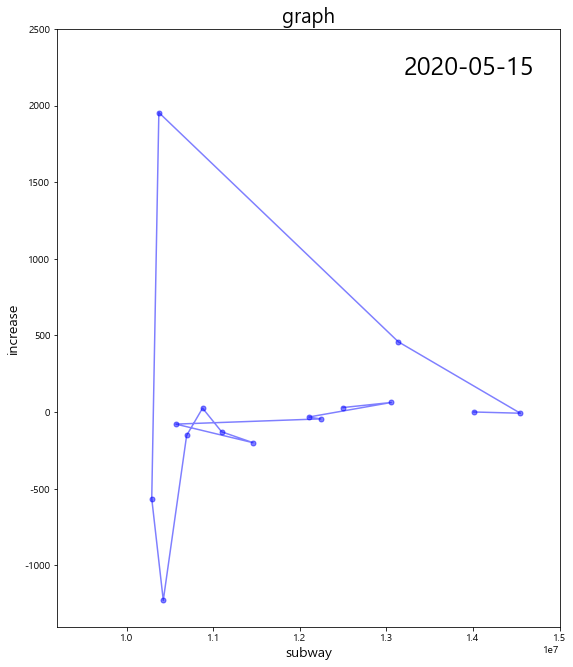

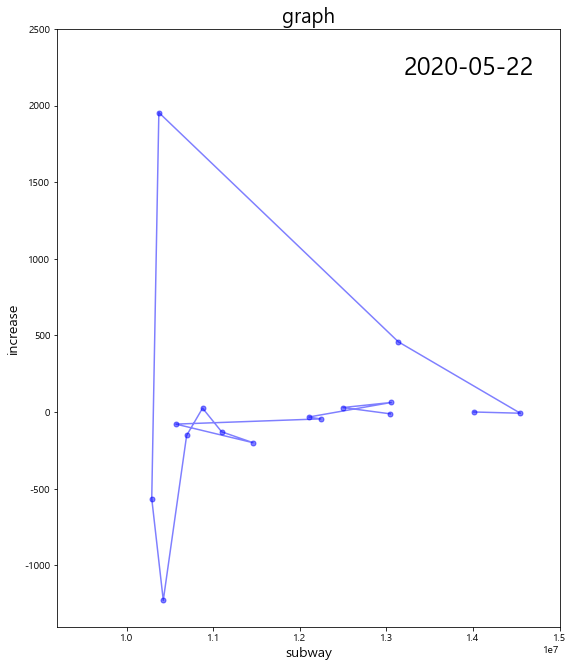

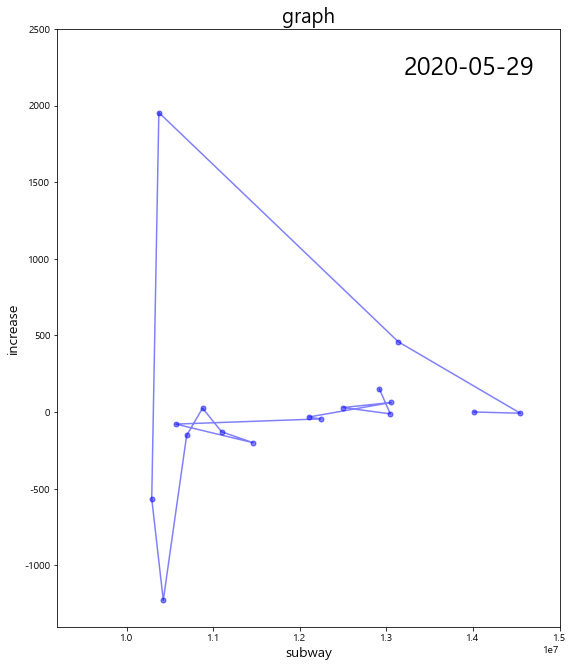

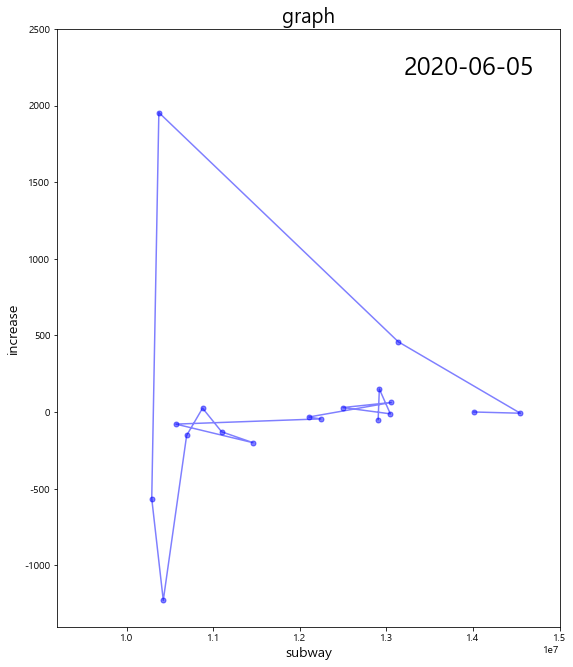

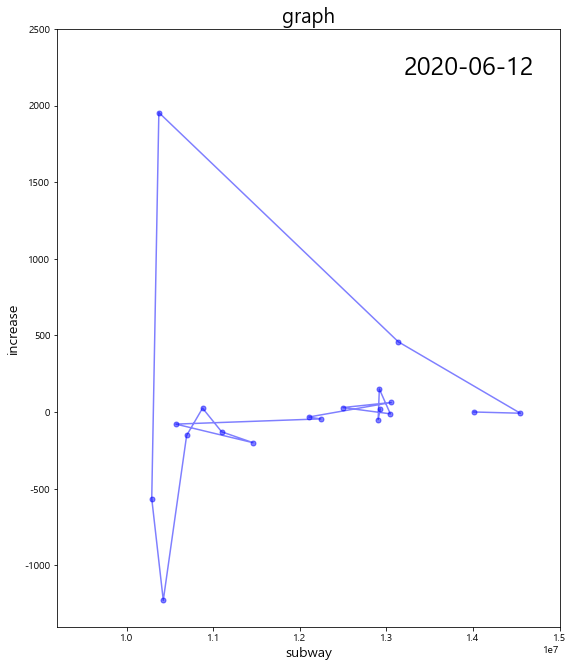

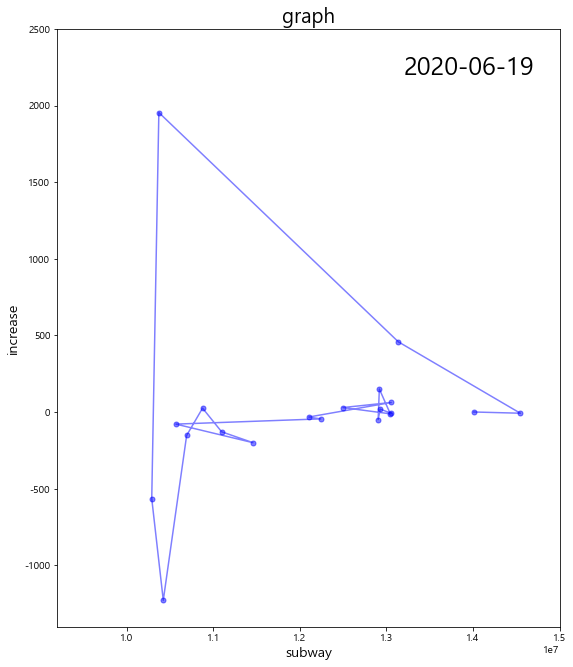

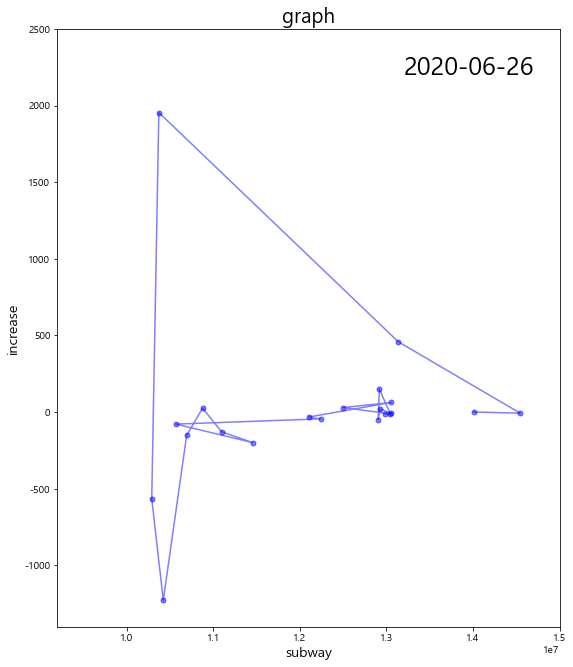

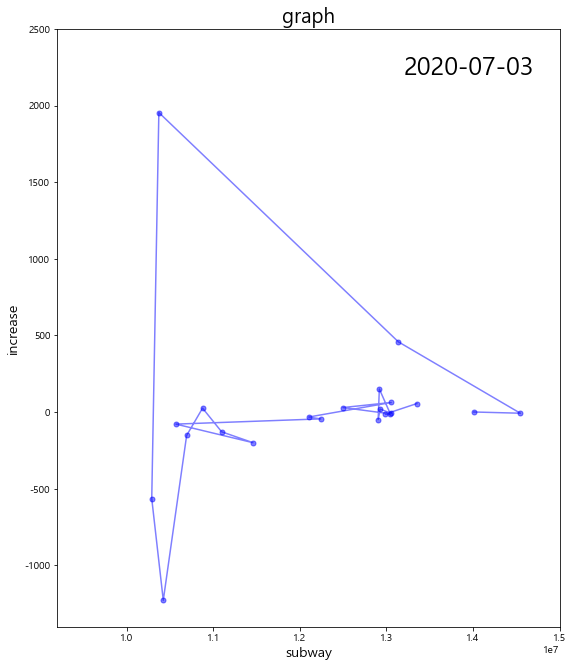

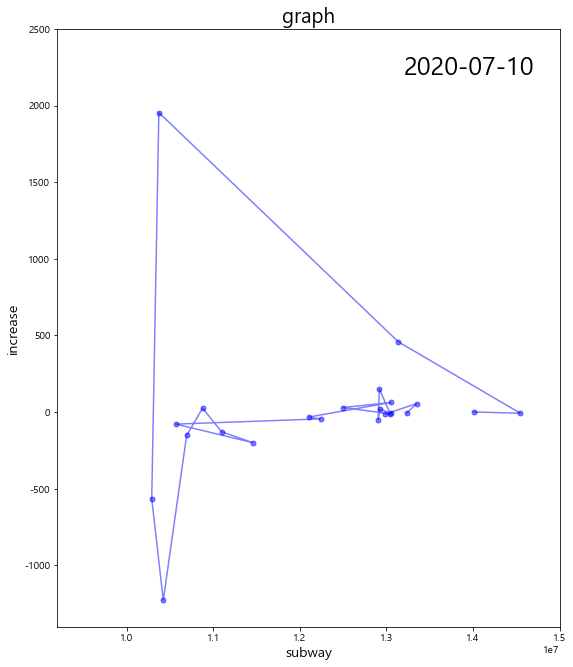

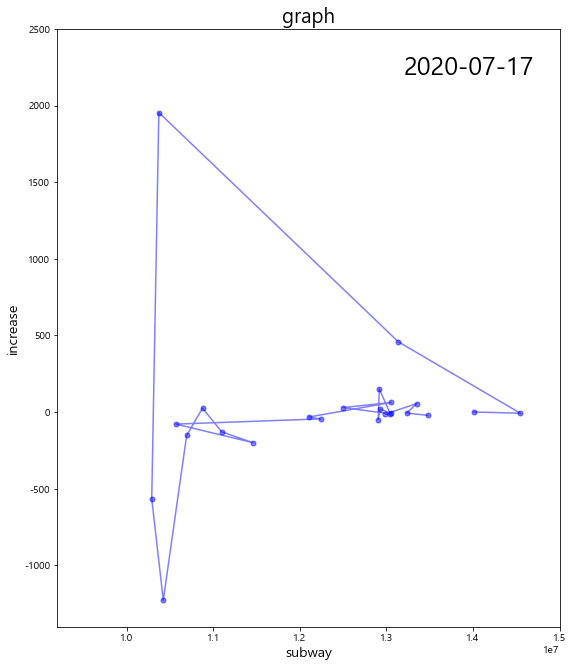

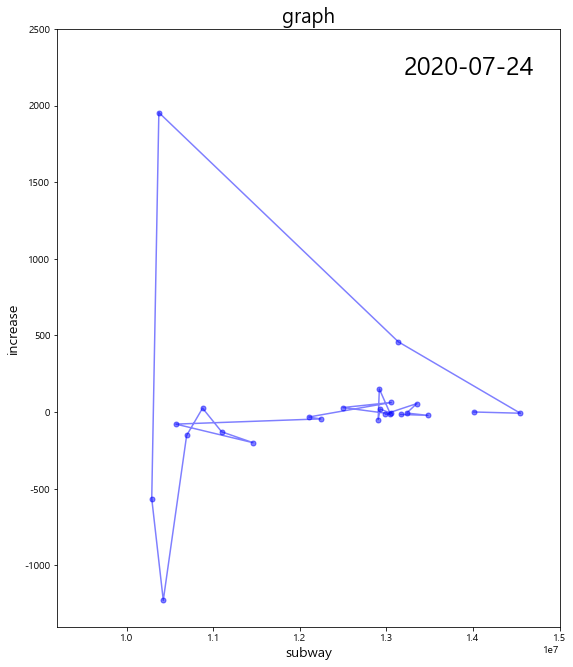

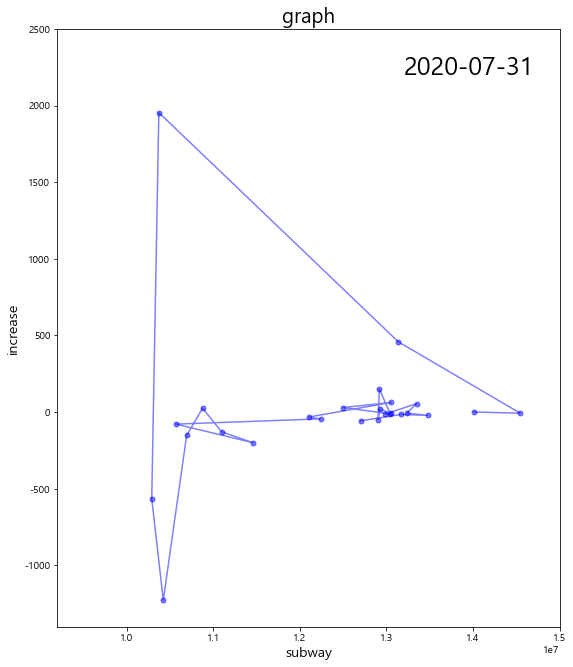

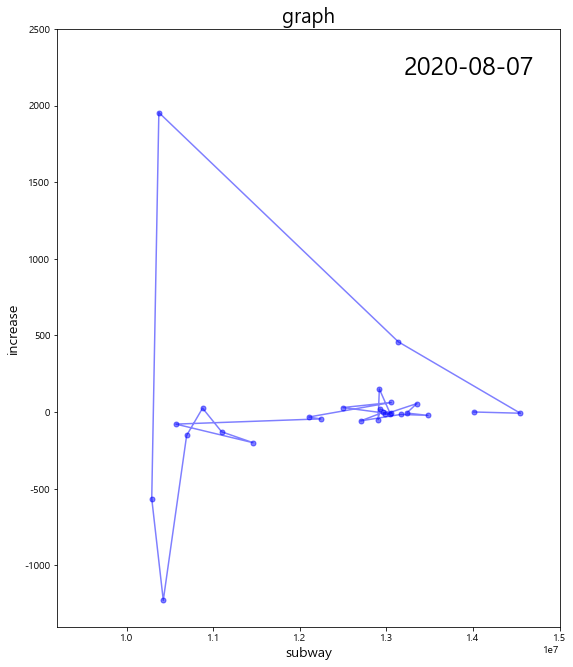

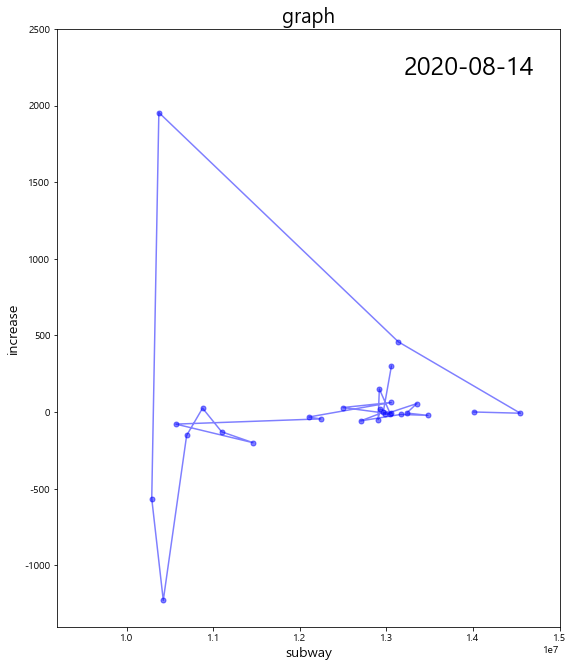

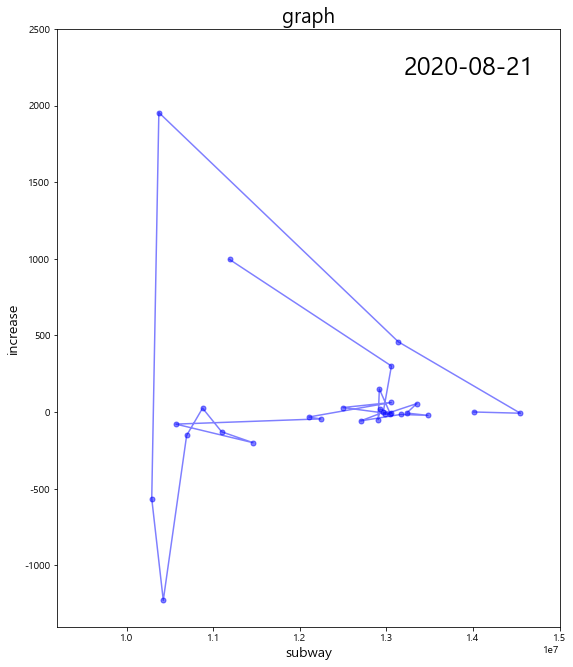

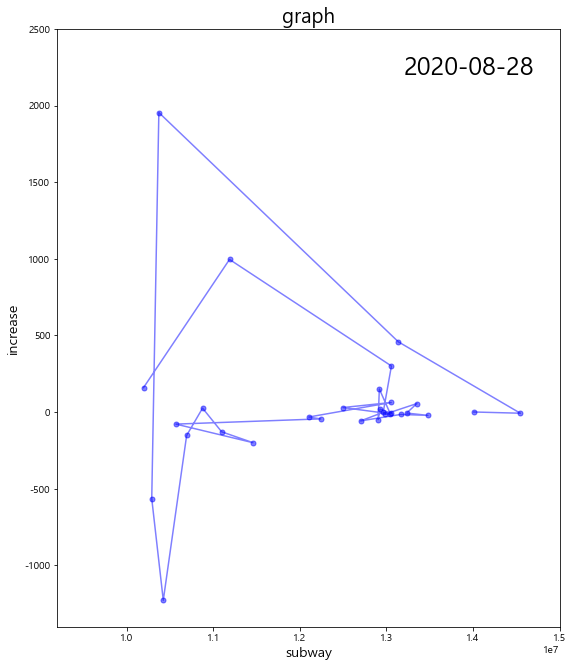

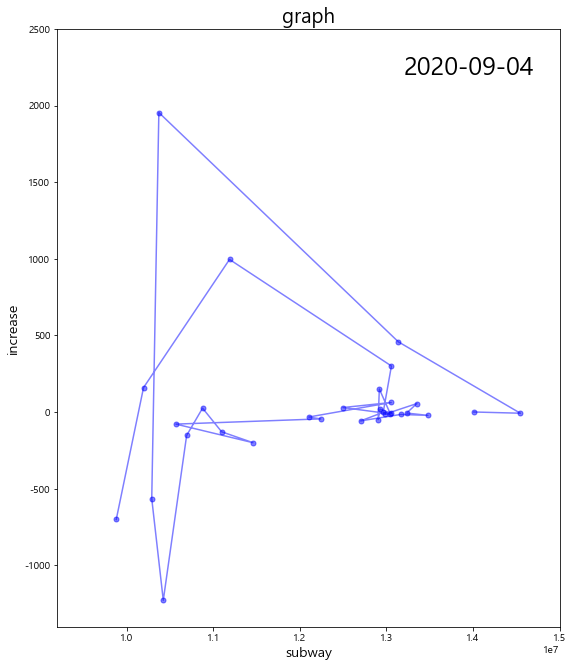

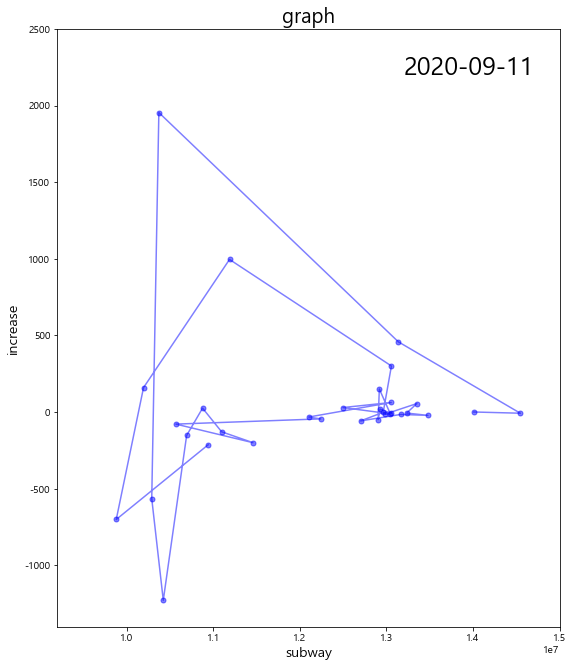

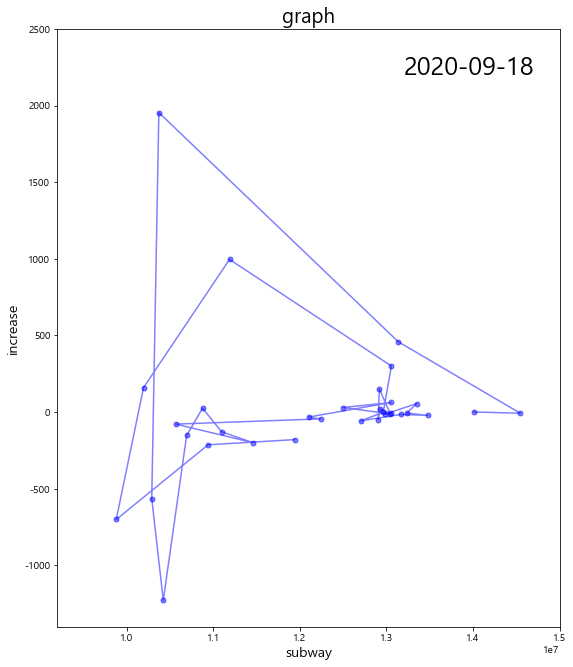

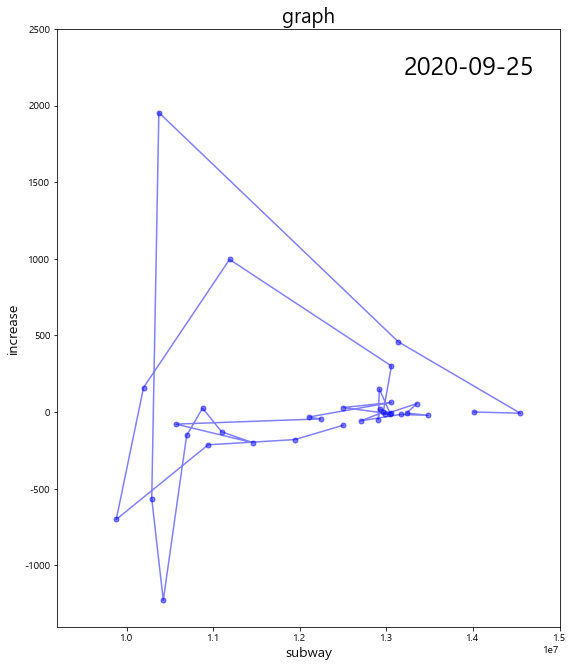

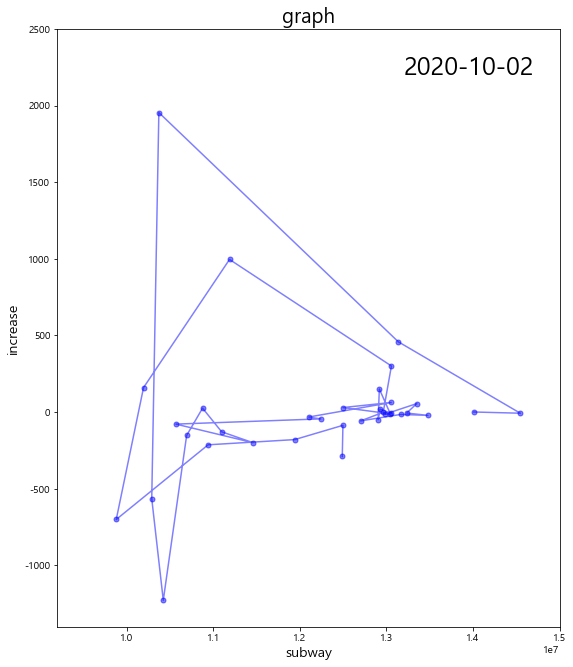

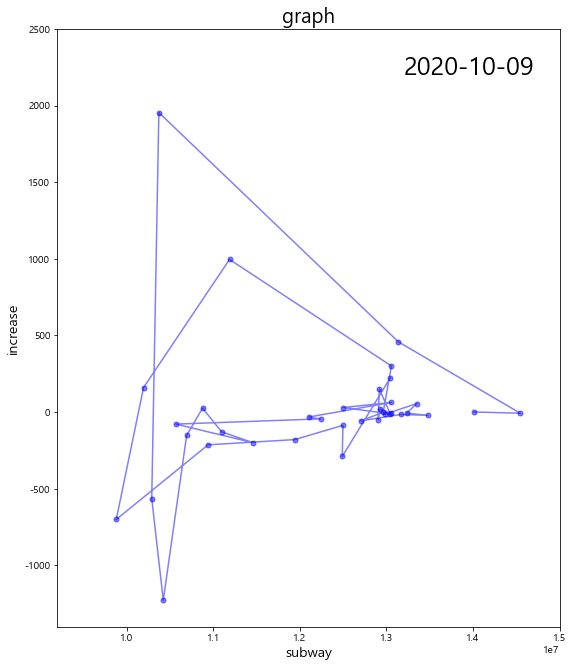

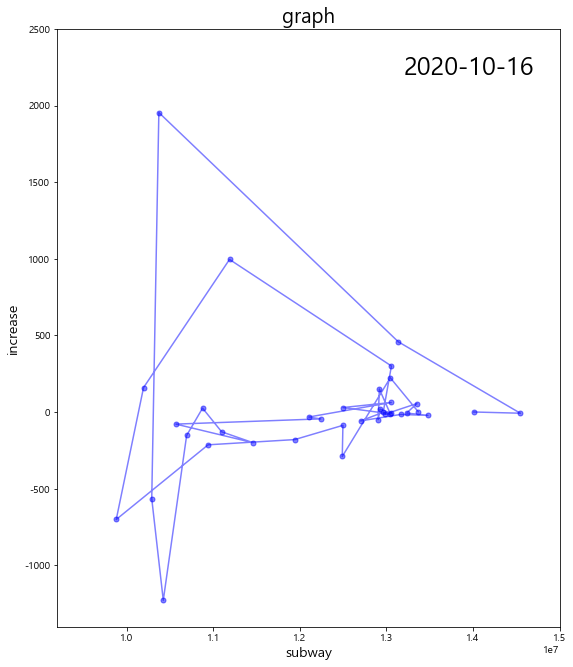

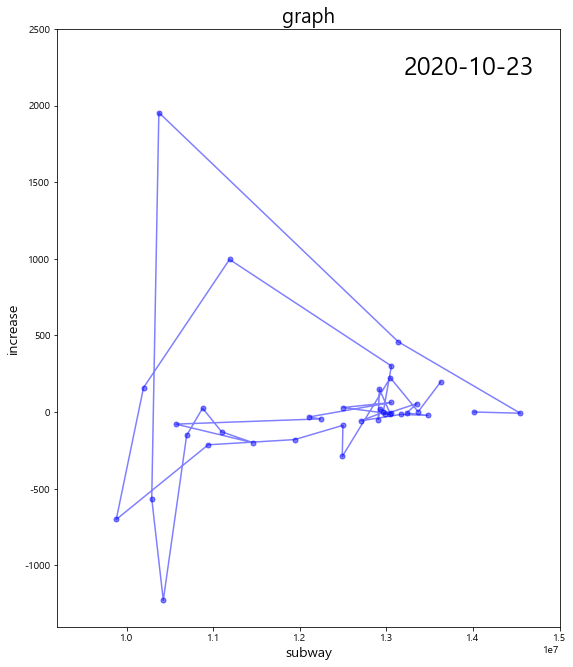

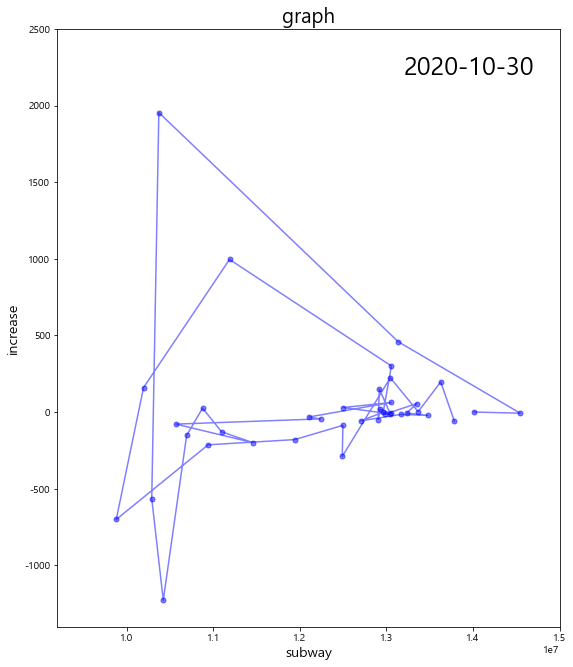

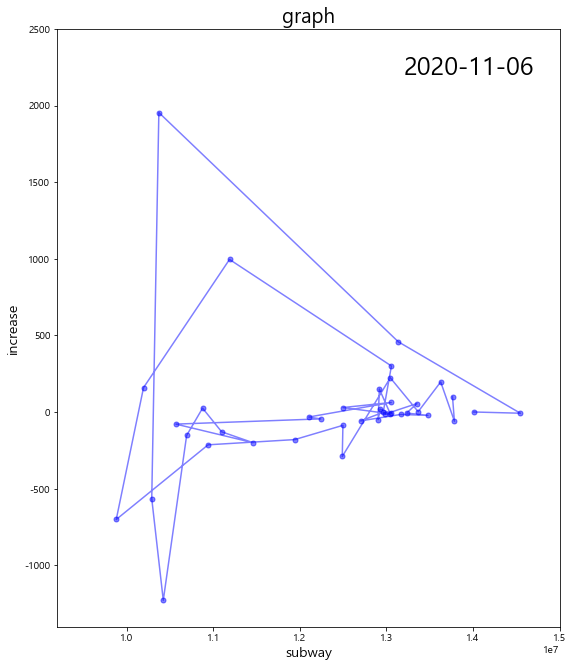

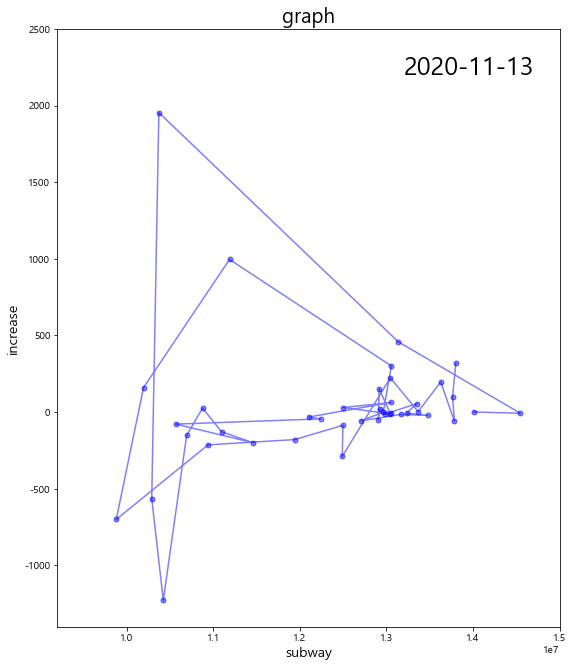

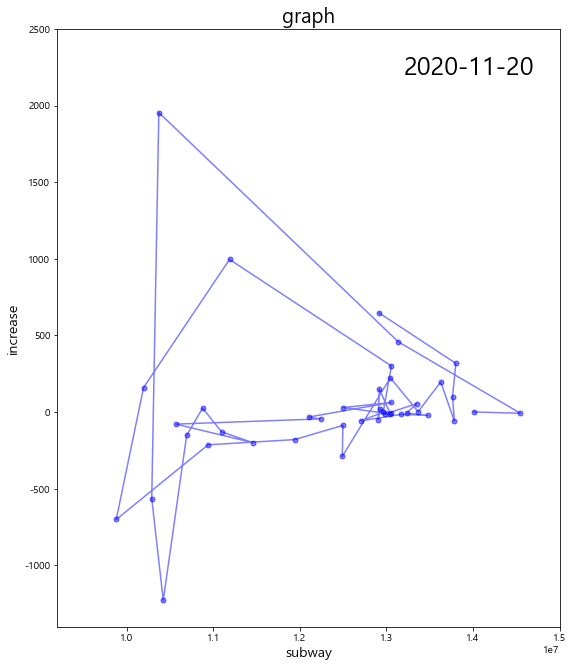

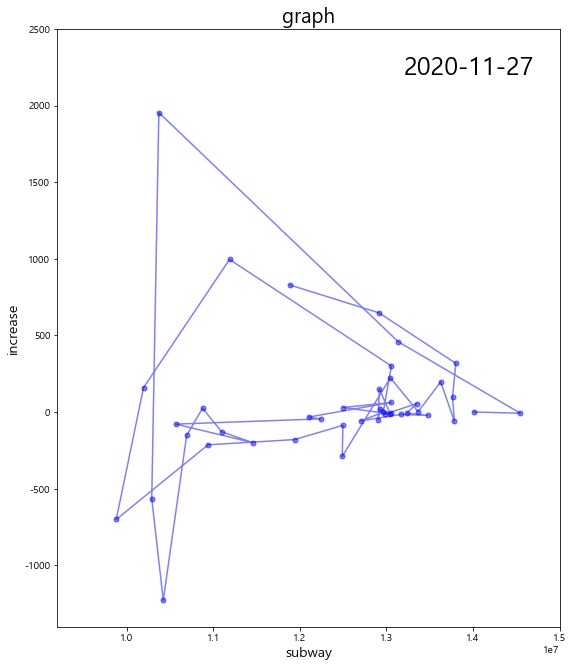

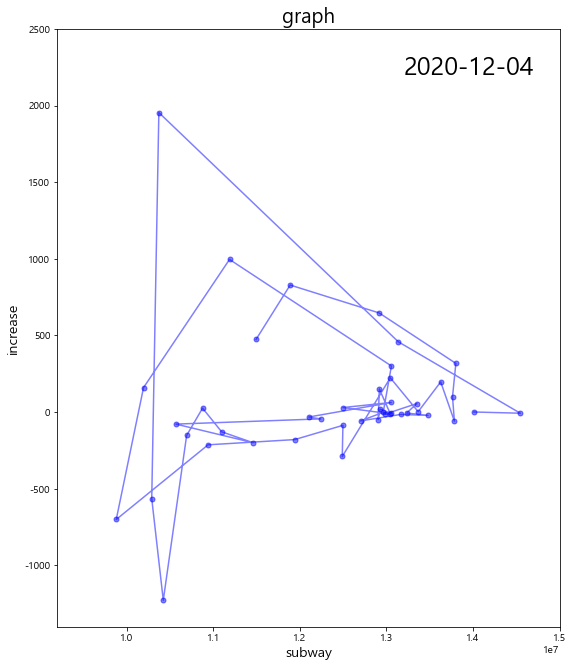

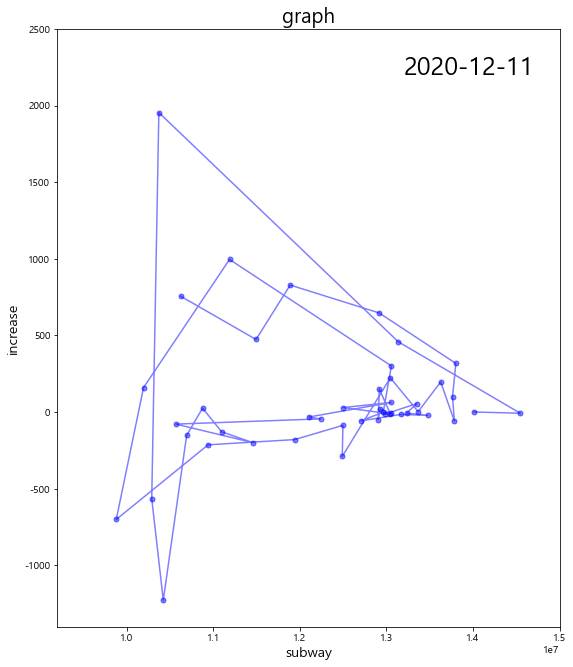

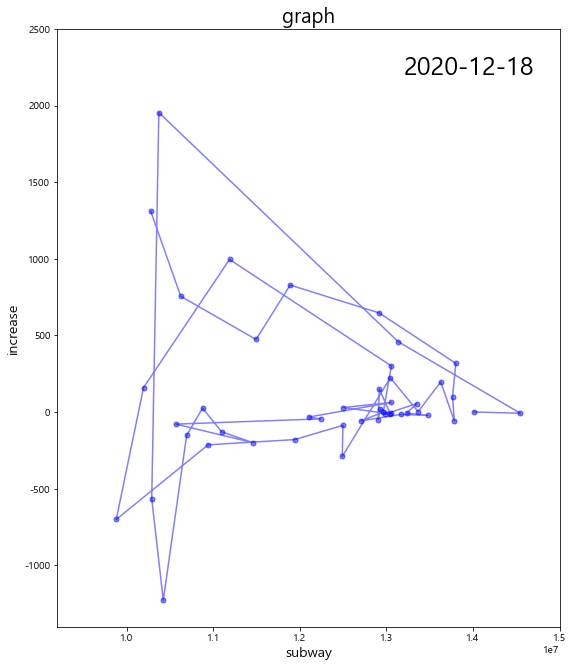

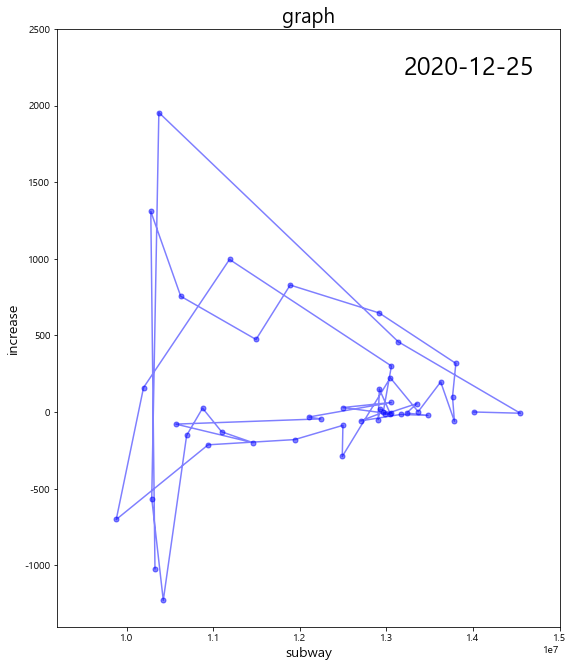

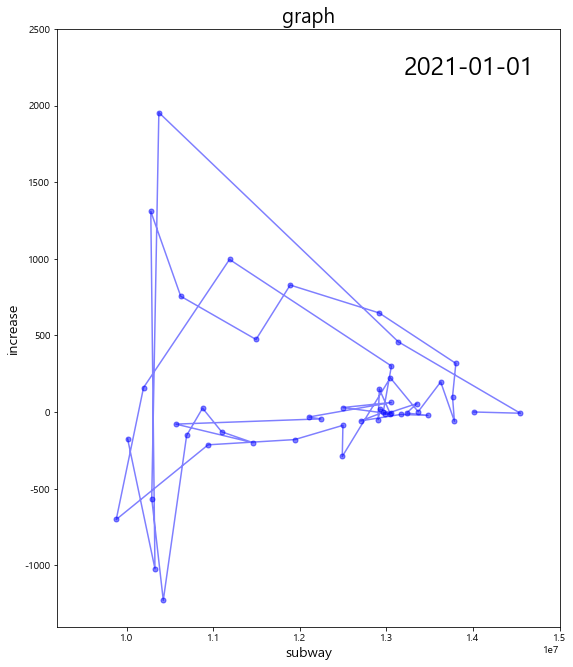

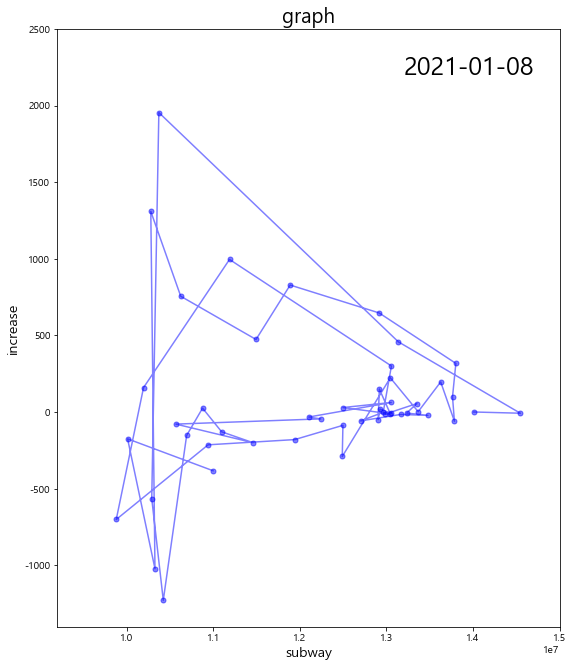

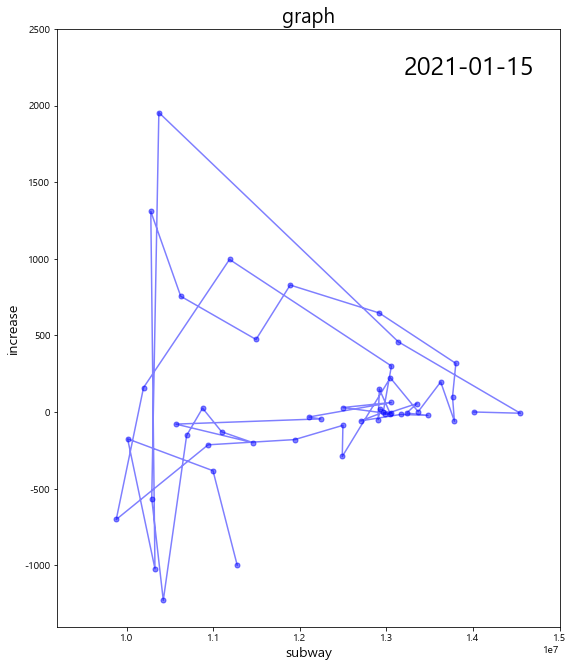

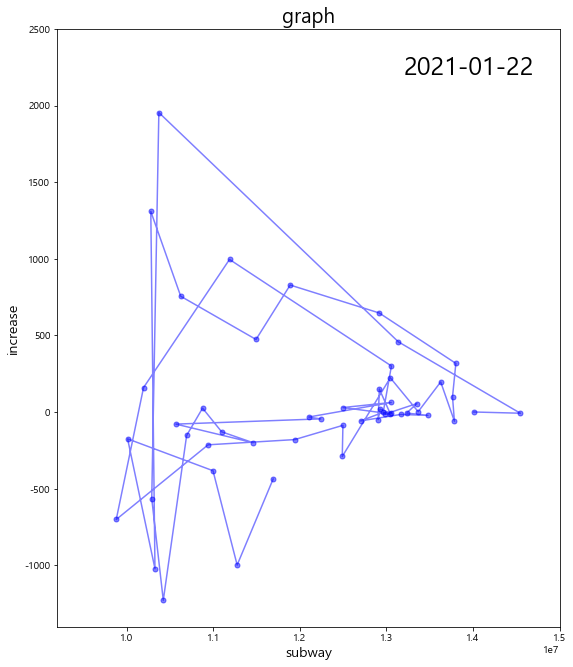

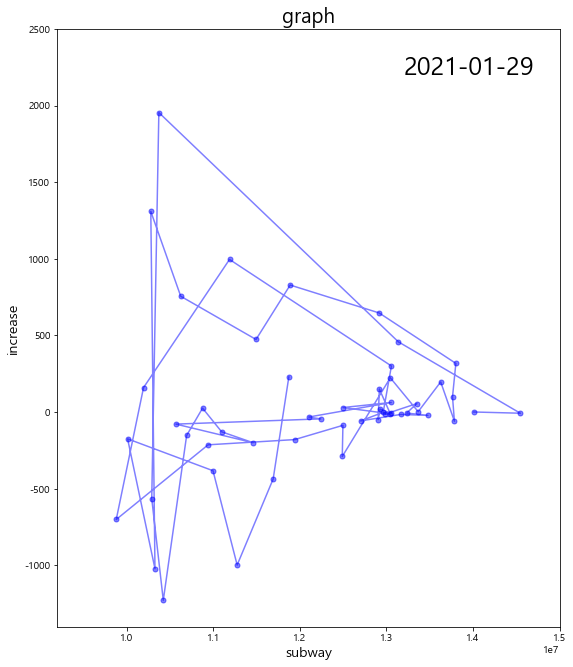

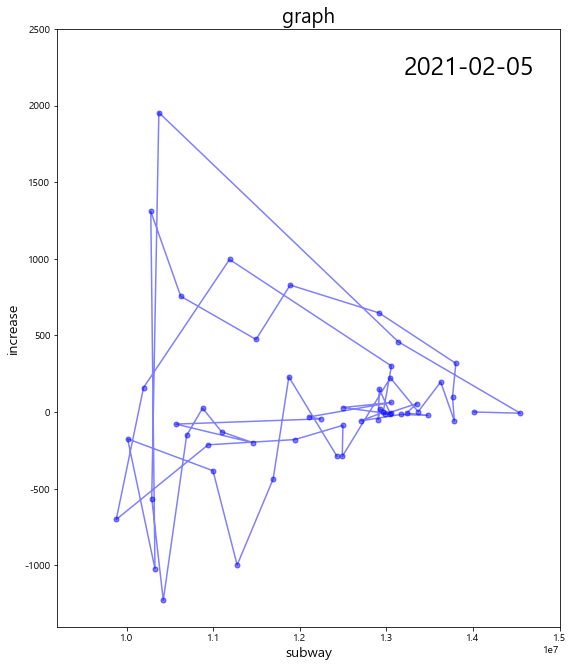

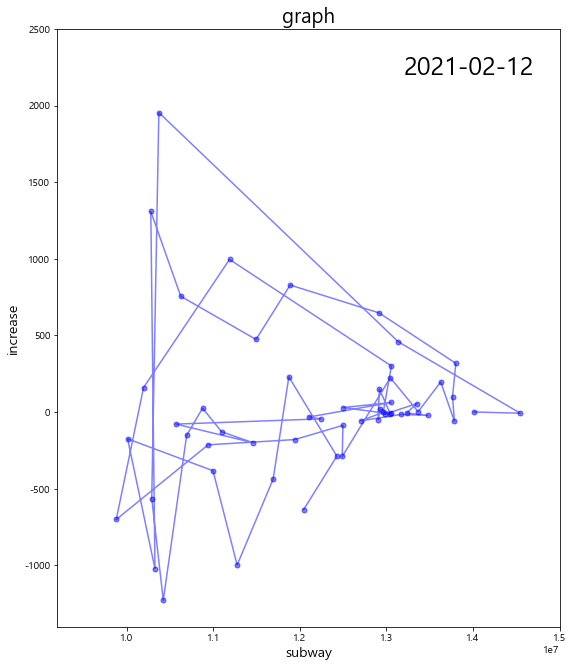

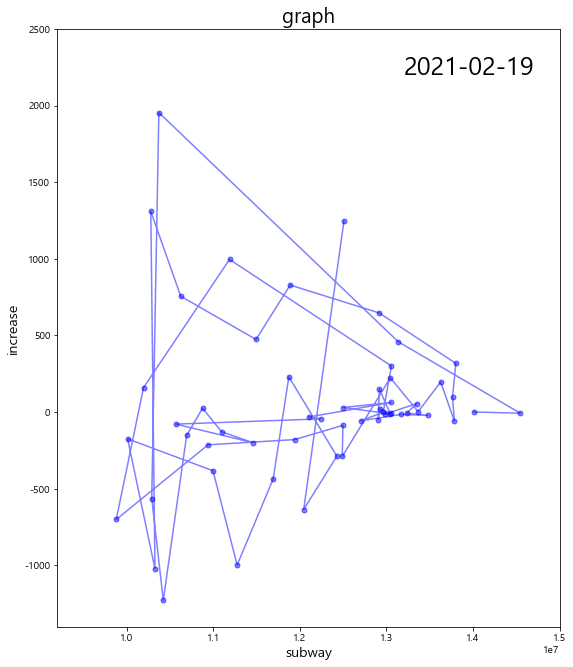

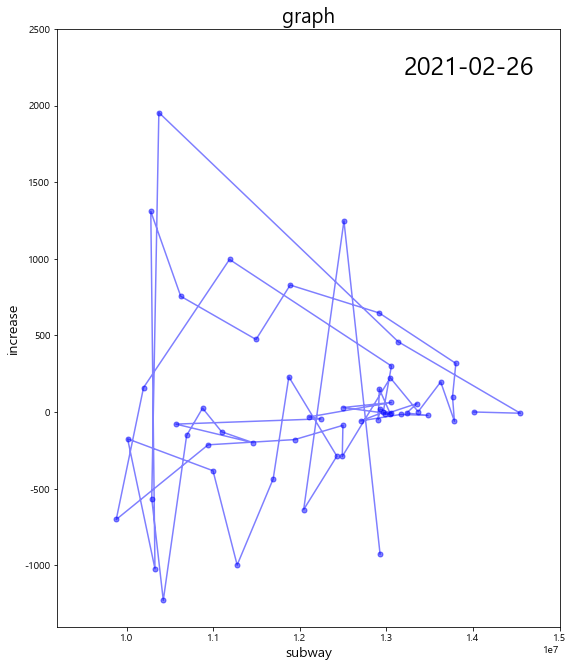

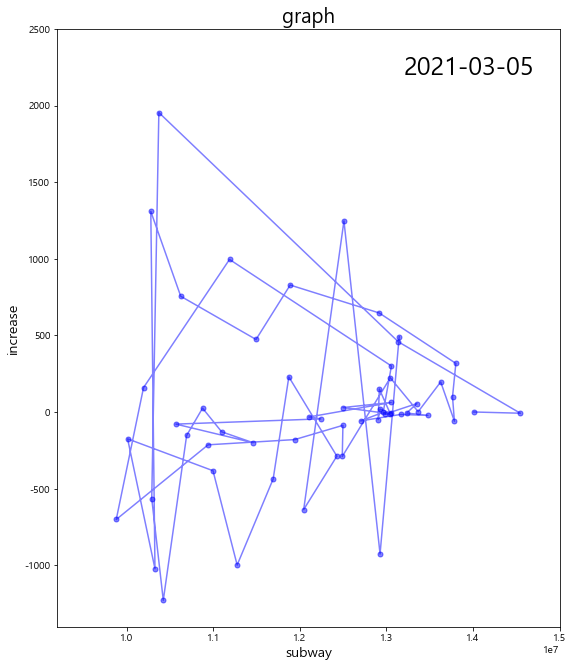

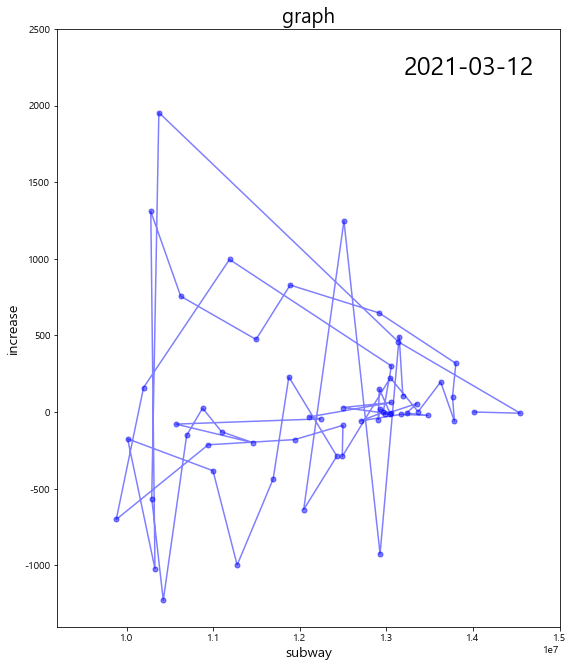

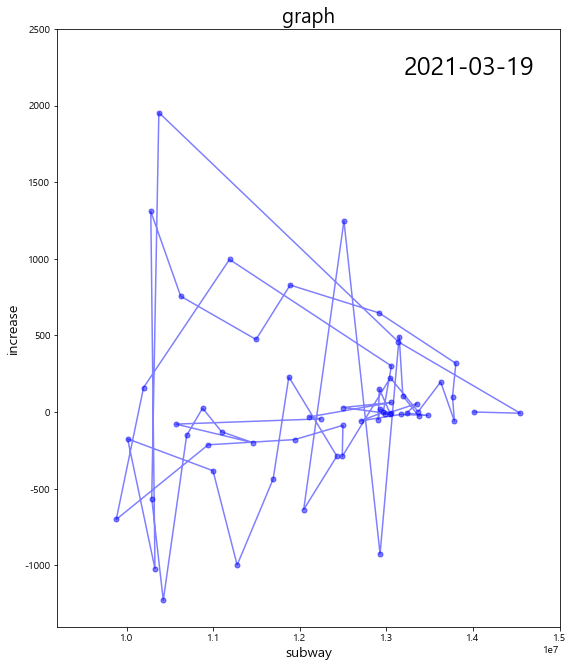

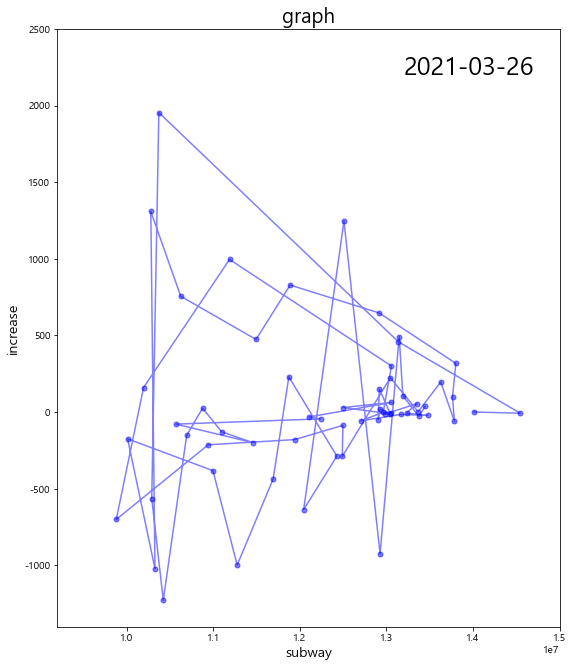

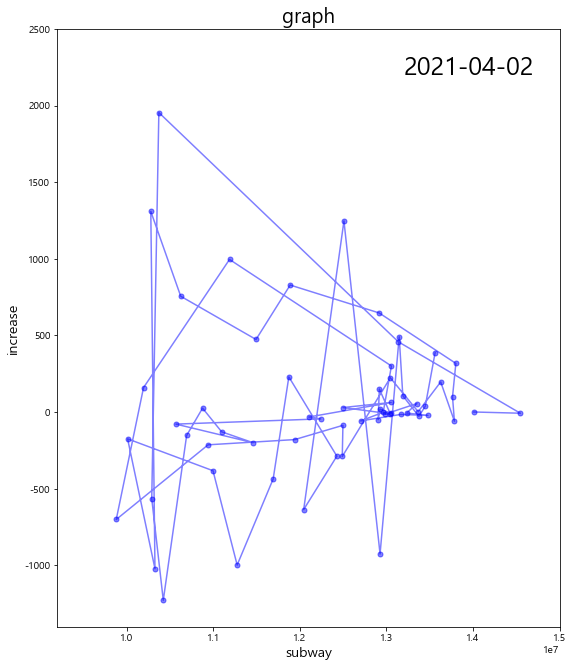

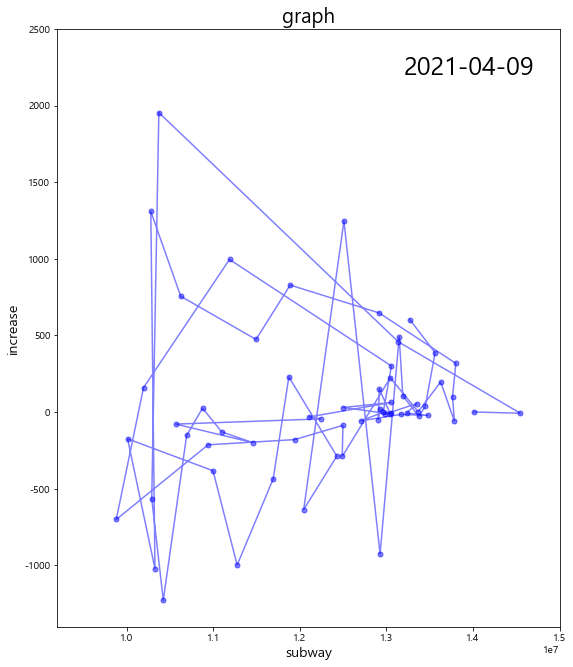

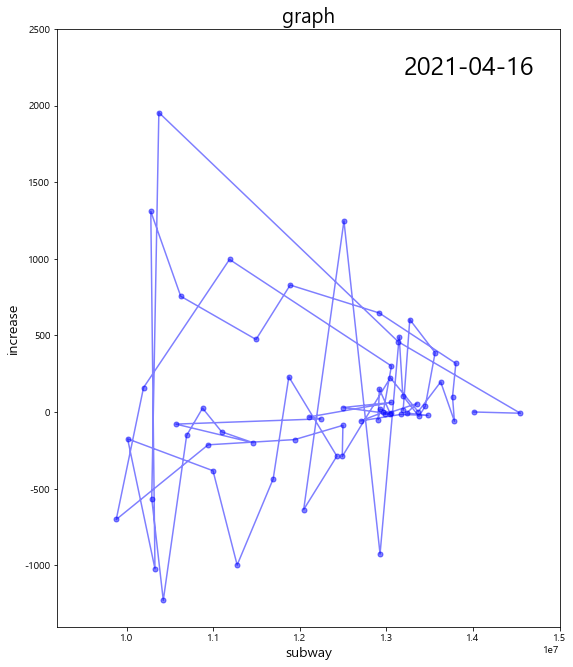

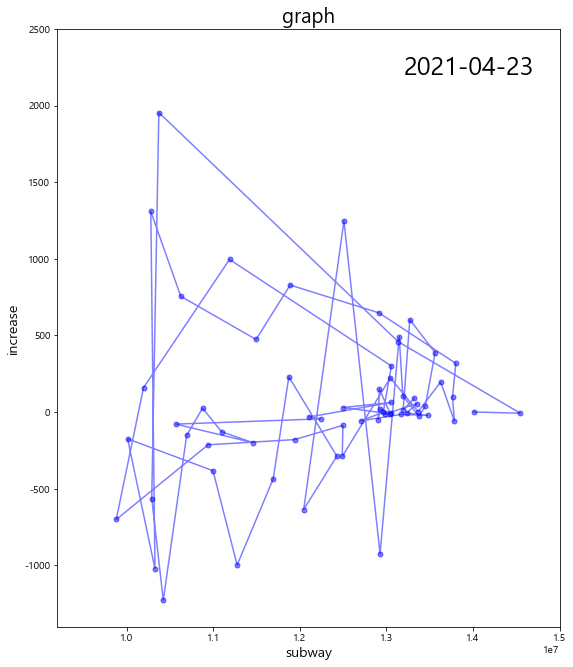

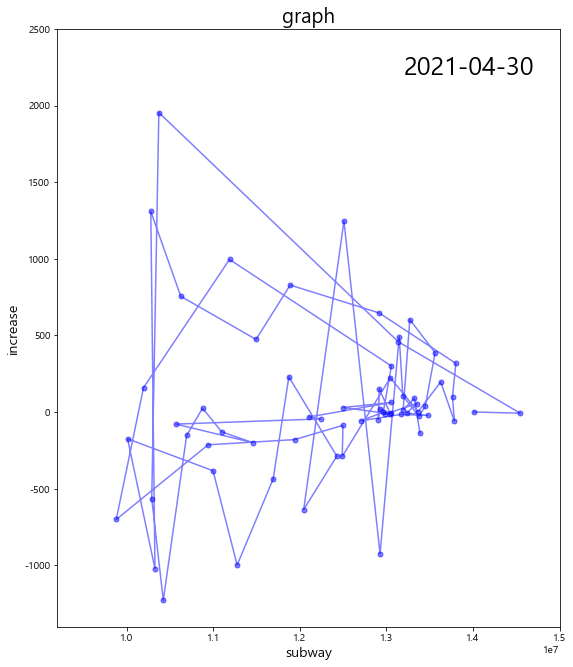

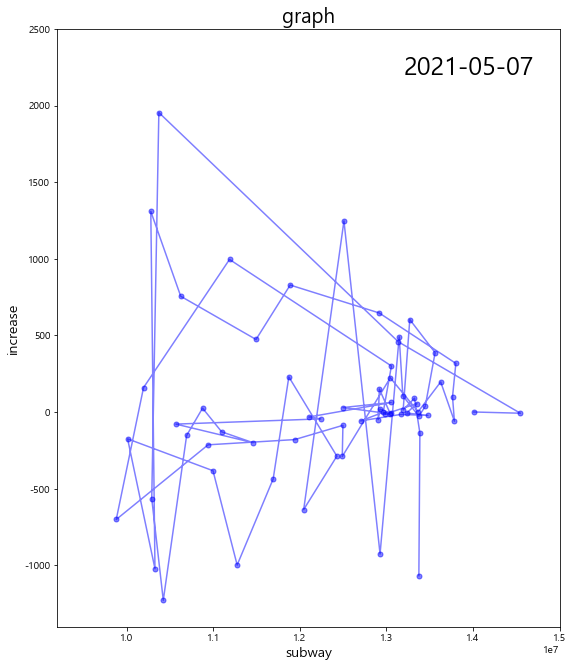

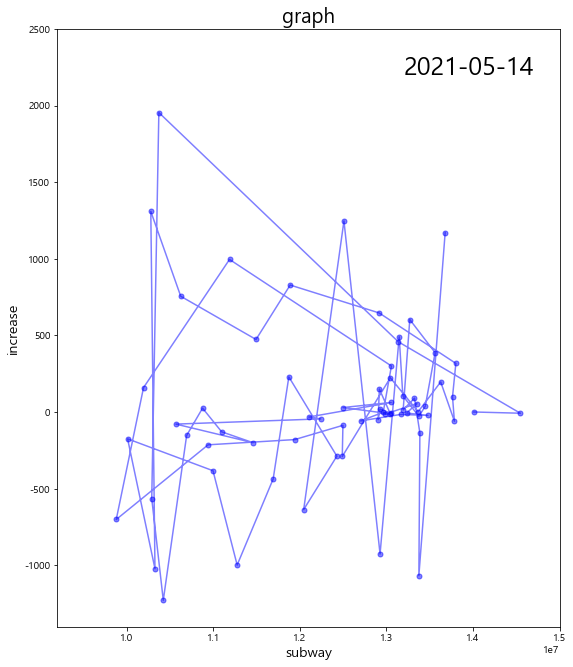

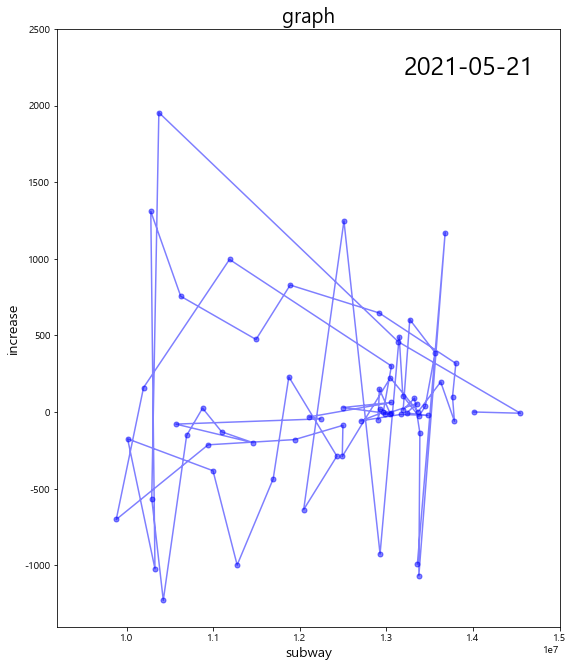

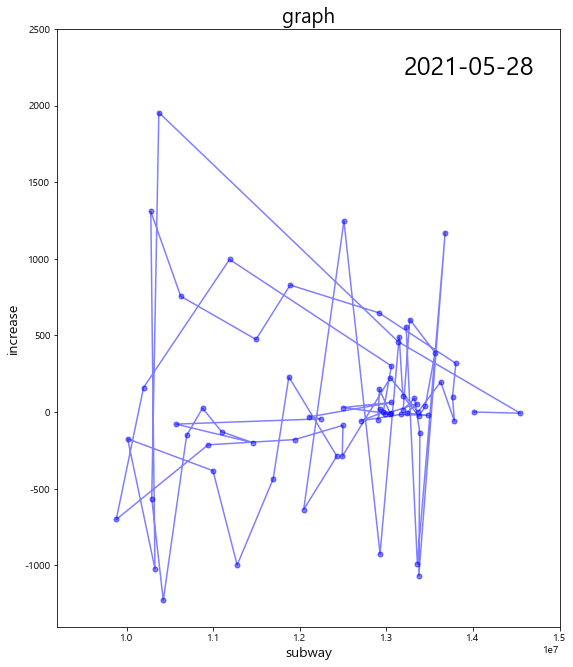

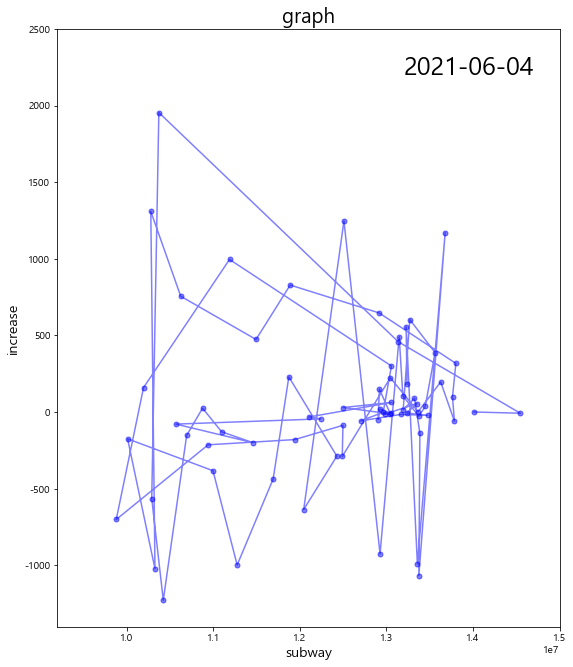

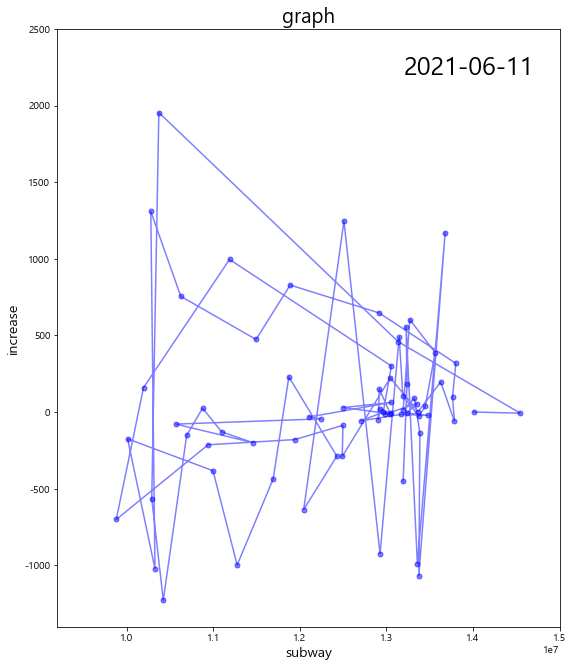

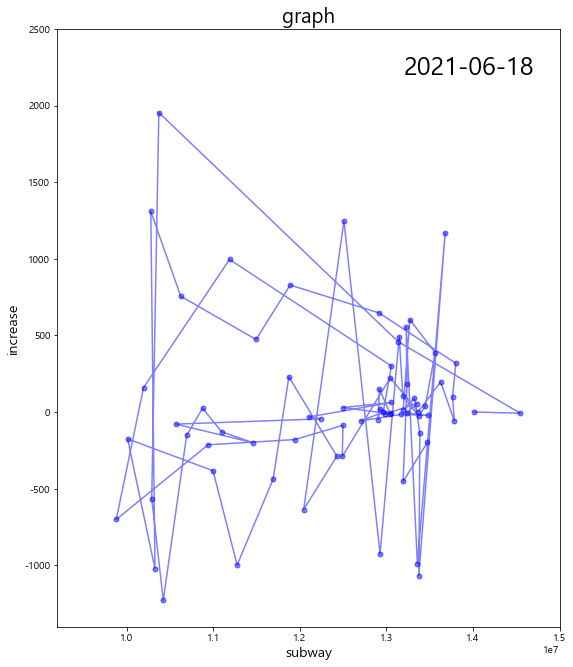

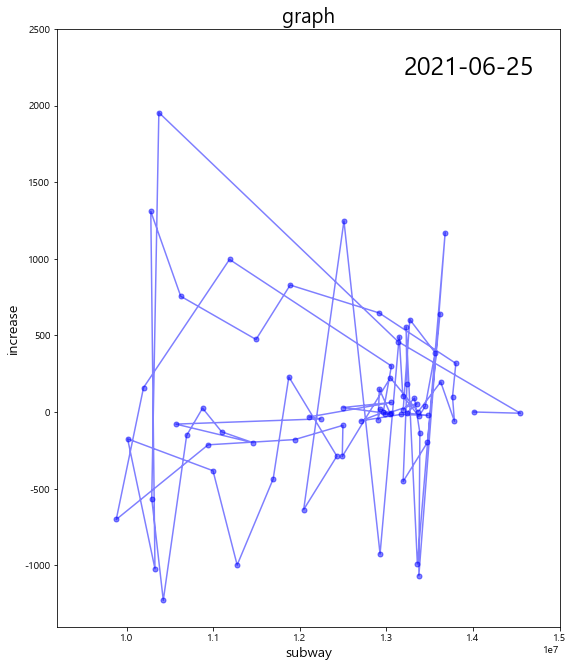

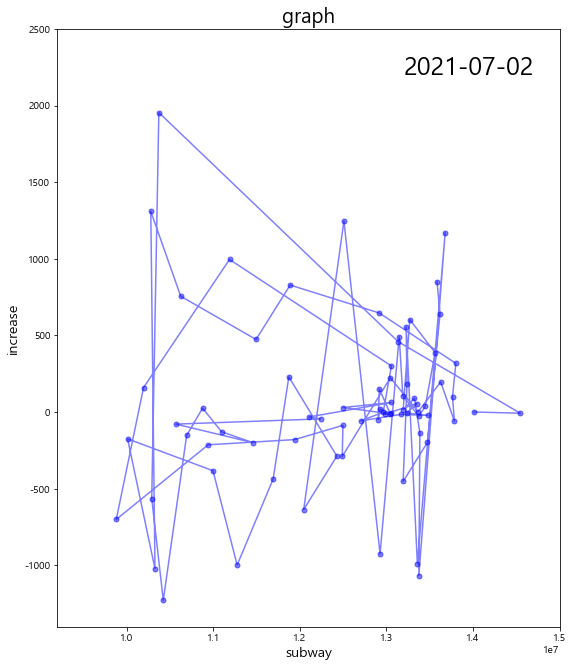

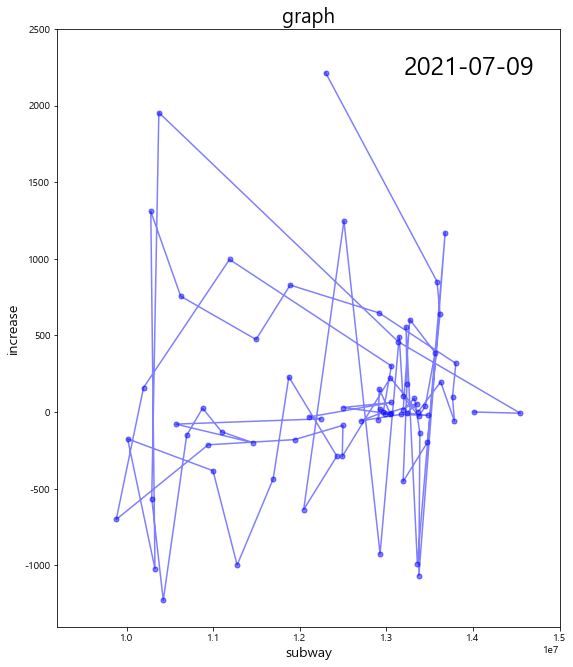

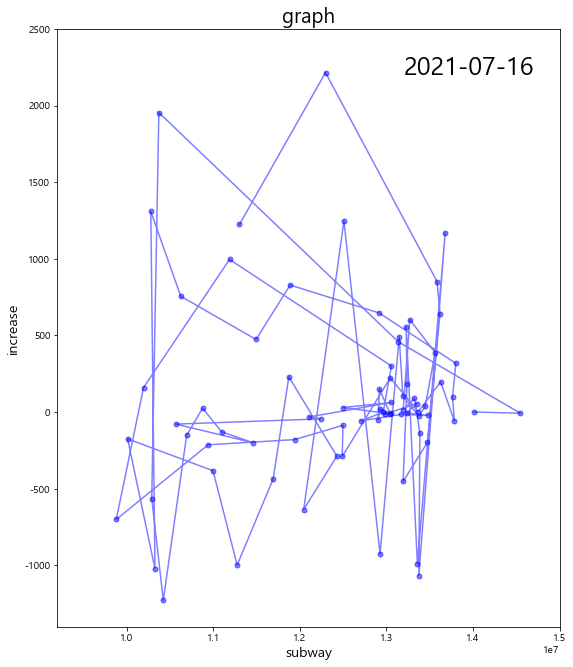

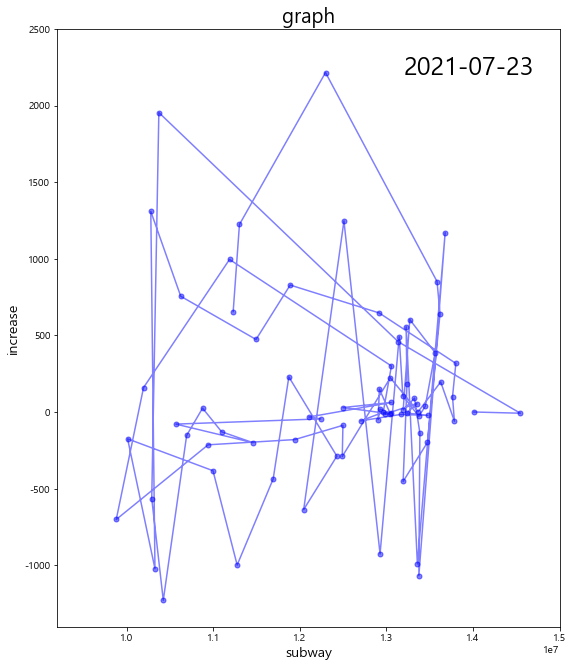

In [54]:
for date in pd.date_range('2020-01-31', '2021-07-27', freq='7D'):
    df_week_temp = slicing(df_week1, '2020-01-31', date)
    
    plt.figure(figsize=(9,11))
    
    plt.axis([9200000, 15000000, -1400, 2500])
    
    plt.plot('subway',

             'increase',

             data=df_week_temp, 

             linestyle='solid', 

             marker='o', 

             markersize=5,

             color='blue', 

             alpha=0.5)

    plt.title("graph", fontsize=20)

    plt.xlabel('subway', fontsize=14)

    plt.ylabel('increase', fontsize=14)

    plt.text(13200000, 2200, str(date)[:10], size=25)
    
    plt.savefig('images/'+str(date)[:10]+'.jpg') # 'images' 폴더가 존재해야 함


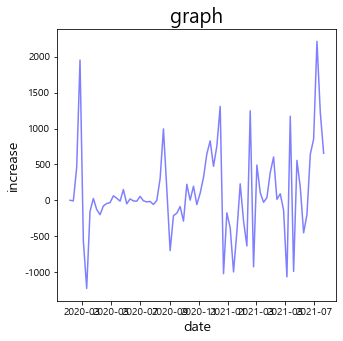

In [52]:

    plt.figure(figsize=(5,5))

    plt.plot('date',

             'increase',

             data=df_week1,

             linestyle='solid', 

             marker='o', 

             markersize=0,

             color='blue', 

             alpha=0.5)

    plt.title("graph", fontsize=20)

    plt.xlabel('date', fontsize=14)

    plt.ylabel('increase', fontsize=14)
    

    
    plt.show()

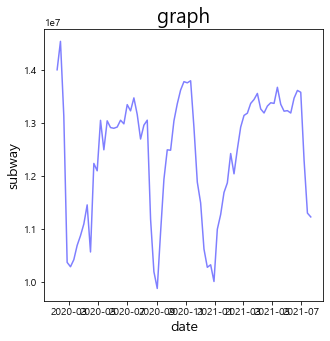

In [53]:

    plt.figure(figsize=(5,5))

    plt.plot('date',

             'subway',

             data=df_week1,

             linestyle='solid', 

             marker='o', 

             markersize=0,

             color='blue', 

             alpha=0.5)

    plt.title("graph", fontsize=20)

    plt.xlabel('date', fontsize=14)

    plt.ylabel('subway', fontsize=14)
    

    
    plt.show()

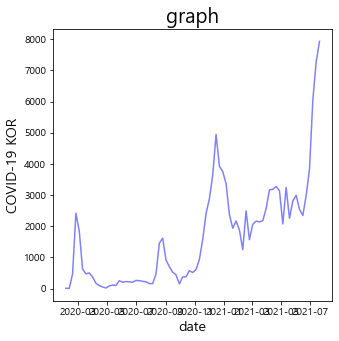

In [51]:

    plt.figure(figsize=(5,5))

    plt.plot('date',

             'COVID-19 KOR',

             data=df_week1,

             linestyle='solid', 

             marker='o', 

             markersize=0,

             color='blue', 

             alpha=0.5)

    plt.title("graph", fontsize=20)

    plt.xlabel('date', fontsize=14)

    plt.ylabel('COVID-19 KOR', fontsize=14)
    

    
    plt.show()

## 전국 신규확진자 vs 1주일 뒤 지하철 승하차수

In [21]:
# 전처리
df_week1_next_week = slicing(df_week, '2020-02-07', '2021-08-03')
df_week1_next_week.set_index(df_week1.index, inplace=True)


In [24]:
df_week1_next_week

,date,subway,COVID-19,COVID-19 KOR
57,2020-02-12,1.454700e+07,0.0,2.0
58,2020-02-19,1.313774e+07,29.0,461.0
59,2020-02-26,1.037252e+07,37.0,2415.0
60,2020-03-04,1.029042e+07,87.0,1851.0
61,2020-03-11,1.042368e+07,55.0,624.0
62,2020-03-18,1.069349e+07,64.0,472.0
63,2020-03-25,1.087733e+07,85.0,498.0
64,2020-04-01,1.109752e+07,74.0,370.0
65,2020-04-08,1.145851e+07,27.0,171.0
66,2020-04-15,1.056939e+07,7.0,93.0


In [25]:
df_week1_with_next_week_subway = df_week1.copy()

In [27]:
df_week1_with_next_week_subway['subway'] = df_week1_next_week['subway']

In [28]:
df_week1_with_next_week_subway

,date,subway,COVID-19,COVID-19 KOR,increase,increase percent
57,2020-02-05,1.454700e+07,4.0,9.0,1.0,12.500000
58,2020-02-12,1.313774e+07,0.0,2.0,-7.0,-77.777778
59,2020-02-19,1.037252e+07,29.0,461.0,459.0,22950.000000
60,2020-02-26,1.029042e+07,37.0,2415.0,1954.0,423.861171
61,2020-03-04,1.042368e+07,87.0,1851.0,-564.0,-23.354037
62,2020-03-11,1.069349e+07,55.0,624.0,-1227.0,-66.288493
63,2020-03-18,1.087733e+07,64.0,472.0,-152.0,-24.358974
64,2020-03-25,1.109752e+07,85.0,498.0,26.0,5.508475
65,2020-04-01,1.145851e+07,74.0,370.0,-128.0,-25.702811
66,2020-04-08,1.056939e+07,27.0,171.0,-199.0,-53.783784


In [29]:
df_week1

,date,subway,COVID-19,COVID-19 KOR,increase,increase percent
57,2020-02-05,1.400990e+07,4.0,9.0,1.0,12.500000
58,2020-02-12,1.454700e+07,0.0,2.0,-7.0,-77.777778
59,2020-02-19,1.313774e+07,29.0,461.0,459.0,22950.000000
60,2020-02-26,1.037252e+07,37.0,2415.0,1954.0,423.861171
61,2020-03-04,1.029042e+07,87.0,1851.0,-564.0,-23.354037
62,2020-03-11,1.042368e+07,55.0,624.0,-1227.0,-66.288493
63,2020-03-18,1.069349e+07,64.0,472.0,-152.0,-24.358974
64,2020-03-25,1.087733e+07,85.0,498.0,26.0,5.508475
65,2020-04-01,1.109752e+07,74.0,370.0,-128.0,-25.702811
66,2020-04-08,1.145851e+07,27.0,171.0,-199.0,-53.783784


In [30]:
df_week1_with_next_week_subway

,date,subway,COVID-19,COVID-19 KOR,increase,increase percent
57,2020-02-05,1.454700e+07,4.0,9.0,1.0,12.500000
58,2020-02-12,1.313774e+07,0.0,2.0,-7.0,-77.777778
59,2020-02-19,1.037252e+07,29.0,461.0,459.0,22950.000000
60,2020-02-26,1.029042e+07,37.0,2415.0,1954.0,423.861171
61,2020-03-04,1.042368e+07,87.0,1851.0,-564.0,-23.354037
62,2020-03-11,1.069349e+07,55.0,624.0,-1227.0,-66.288493
63,2020-03-18,1.087733e+07,64.0,472.0,-152.0,-24.358974
64,2020-03-25,1.109752e+07,85.0,498.0,26.0,5.508475
65,2020-04-01,1.145851e+07,74.0,370.0,-128.0,-25.702811
66,2020-04-08,1.056939e+07,27.0,171.0,-199.0,-53.783784


In [31]:
df_week1_with_next_week_subway.corr()

,subway,COVID-19,COVID-19 KOR,increase,increase percent
subway,1.000000,-0.342429,-0.407040,-0.173987,-0.173375
COVID-19,-0.342429,1.000000,0.957764,0.418705,-0.099268
COVID-19 KOR,-0.407040,0.957764,1.000000,0.418441,-0.082258
increase,-0.173987,0.418705,0.418441,1.000000,0.083481
increase percent,-0.173375,-0.099268,-0.082258,0.083481,1.000000


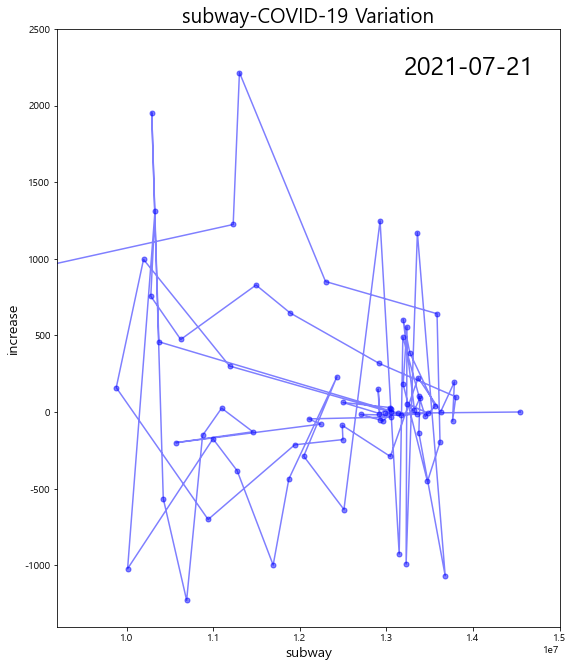

In [39]:
# test : subway - increase

plt.figure(figsize=(9,11))
plt.axis([9200000, 15000000, -1400, 2500])
plt.plot('subway',

         'increase',

         data=df_week1_with_next_week_subway,

         linestyle='solid', 

         marker='o', 

         markersize=5,

         color='blue', 

         alpha=0.5)

plt.title("subway-COVID-19 Variation", fontsize=20)

plt.xlabel('subway', fontsize=14)

plt.ylabel('increase', fontsize=14)

plt.text(13200000, 2200, '2021-07-21', size=25)


plt.show()